In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Our report is organized in such a way, that at each section, we first import the results from the computations made by the functions in *utilities.py*.

A summarized explanation on how we computed these results then immediately follows after importing them.

For detailed commentary on the code steps, refer to the corresponding functions in utilities.py."

# Data Understanding

## 1. Exploratory Data Analysis

- Examination and understanding of the dataset's structure and content.
- Performing exploratory data analysis to understand data patterns, outliers, and relationships between variables.

Summary of the Data Exploration:  

There are many redundancies in the data. The business_entity_doing_business_as_name uniquely defines the compset_group,  the list of compsets, legal_entity_name, domicile_country_name, ultimate_parent_legal_entity_name and primary_exchange_name. Additionally there are duplicate rows only differing in the compset. 

To remove redundancies and format the data in a suitable way for further analysis we created a clean_data function. The functionality of the function is described below:

We checked in Data_Cleaning_js.ipynb that the column names listed above do not change over time for any business_entity_doing_business_as_name. There are also no NaNs in business_entity_doing_business_as_name, this column can therefore be interpreted as keys, defining the other entries in the other columns listed above. We therefore extract these meta-information into a different data-frame called df_brands.

Additionally the summary rows with compset='All Brands' are extracted to a data-frame df_allbrands.

The main df now contains only the period_end_date, business_entity_doing_business_as_name and the five numerical quantities. Additionally a list of brands, compsets, compset_groups is provided


In [3]:
from utilities import clean_data

In [4]:
df, df_brands, df_allbrands, brands, compsets, compset_groups, groups_bycompset = clean_data()

### Heatmap

Implementing a heatmap to determine which correlations are noteworthy

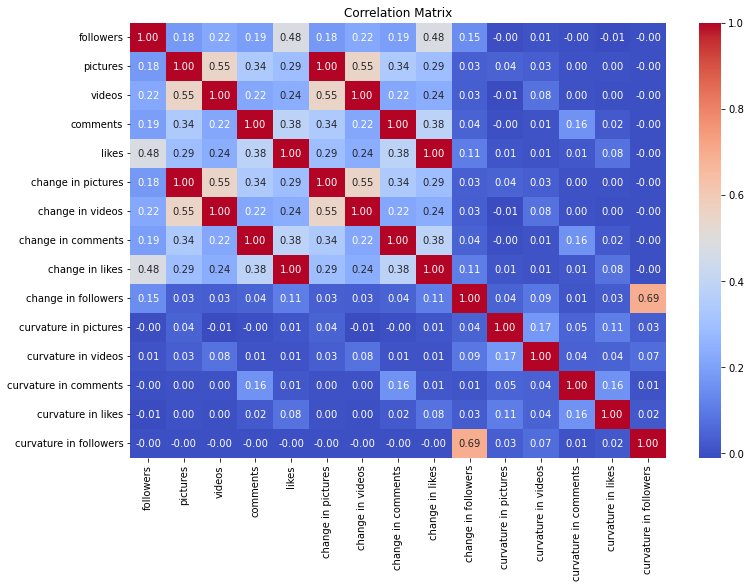

In [16]:
from utilities import derivatives_data
df_rate, df_curvature = derivatives_data(df)

corr_mat = df.corr()
corr_mat_rate = df_rate.corr()
corr_mat_curv = df_curvature.corr()

import seaborn as sns

df_concatenated = pd.concat([df, df_rate, df_curvature], axis=1)

# Compute the correlation matrix
correlation_matrix = df_concatenated.corr()

# Plot the heatmaps
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

We can see a significant correlation in the change of followers and the curvature of the followers data.
In a mathematical sense, if f(t) is the number of followers for a given time t, this correlation somewhat corresponds to the relation
f'(t) ~ f''(t)
where f'(t) and f''(t) denote the first and second time derivative respectively, and ~ is the sign for proportionality.
this differential equation can be solved, revealing the solution for f(t) = f(0)*exp(c*t), where c is a constant.
The correlation coefficient of 0.69 shows tendencies towards exponential growth of follower numbers for the companies in many cases.

## 2. Data Cleaning

### Handling Missing Values

In [5]:
from utilities import missing_df, missing_values

In order to get a feeling of the distribution and magnitude of the missing values, we created a new datafram *missing_df* containing the total number of entries per business and the total number of missing values per business per category.

In [6]:
missing_df = missing_df(df)

print(missing_df.shape)
missing_df.head()

(705, 7)


Business  Total Entries:  Missing followers:  Missing pictures:  \
0                24S             333                  20                  1   
1    3.1 Phillip Lim             455                  18                  0   
2                3CE             455                 131                  0   
3  A. Lange & Soehne             403                   8                  3   
4            ANIMALE             403                 131                  0   

   Missing videos:  Missing comments:  Missing likes:  
0                1                  1               1  
1                0                  0               0  
2                0                  0               0  
3                2                  2               2  
4                2                  0               0

In the function *missing_values()*, we reorganized the DataFrame *df* by date and business, revealing numerous initial missing-value-series across many businesses. By removing these initial series, we reduced the number of rows containing at least one missing value from 65,868 to 4,378.

By identifying the lengths and locations of all remaining missing-value-series in the data, we manage to further decrease the number of rows containing at least one missing value to 4,145. This represents a $ 94 \% $ decrease in rows containing at least one missing value.

In [7]:
cleaned_df = missing_values(df)

Number of rows with at least one NaN before cleaning: 65868
Number of rows with at least one NaN after dropping series of Nan's at beginning of businesses: 4378

 Remaining number of rows with Nan that are not at beginning or end:
Number of rows with 4 NaNs: 3214
Number of rows with 3 NaNs: 0
Number of rows with 2 NaNs: 7
Number of rows with 1 NaNs: 924
Total remaining rows with at least one Nan:  4145

 Total number of rows after cleaning: 236317


Based on the following facts:
- Most of the remaining missing values were are all series of lengths greater than 20, spread randomly through the data.
- There were only 4,145 of the total of 236,317 rows left that contained at least one missing value.

We made the following **assumption**:
- We assumed that the remaining missing values would not affect the performance of our model significantly.

Based on that we decided to leave the remaining missing values for now, and check after implementing the model wether our assumption was correct.

 

### Normalization

In [8]:
from utilities import normalization

The Normalization function is a useful tool when building ML models that work off the number of followers, likes, etc. It Easily scales the Data Frame down by many orders of magnitude.
For example, the number of 'likes' for 'Pepsi' is transformed into its ratio of total likes across all companies, given by the 'likes' from 'All Brands (Study)'

We added it to our utilities since it can be applied in many instances and for easy access

### Computing Derivatives

In [9]:
from utilities import derivatives_data

In [10]:
df_rate, df_curvature = derivatives_data(df)

In the context of wanting to predict outliers and deviations, it is useful to look at time derivatives, gradients etc...
Since the time resolution is fixed at weekly intervals, the derivative of our numerical data will be proportional to simply its difference from one week to the next. From this basic idea we built a function "derivatives_data" which computes two dataframes:
- df_rate_of_change: this contains the first time derivative (slope) of all parameters 'followers', 'likes' ...
- df_curvature     : this contains the second time derivative (curvature) of all parameters 'followers', 'likes' ...

# Modeling Approach

## 1. Feature Engineering

- Feature engineering to create relevant features for identifying deviations.

### Ranking the followers

By grouping the brands (business_entity_doing_business_as_name) by compset_group one can compare the follower development of each brand in the respective sectors. We use the change in follower ranking among the companies as a metric to quantify the performance of each brand relative to its competitors. Specifically for each compset_group the brands are ranked by their amount of followers and the change of this rank is documented in a new column of the dataframe (see the ranking_followers function).

In [11]:
from utilities import ranking_followers
from scipy.signal import find_peaks
import math

In [12]:
cgroup_ranking, brands_by_cgroup = ranking_followers(df, df_brands, compset_groups)

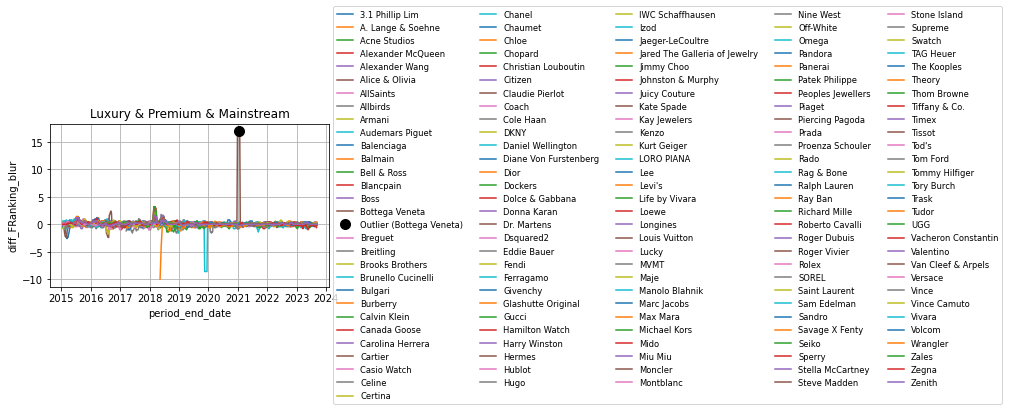

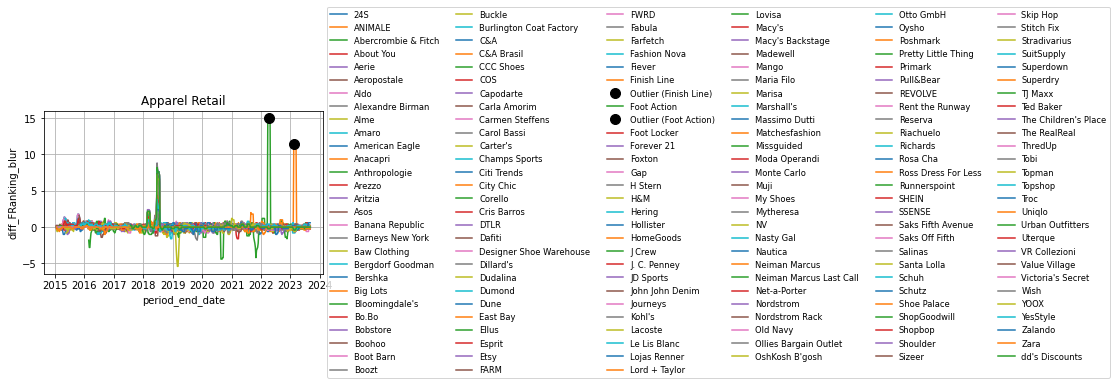

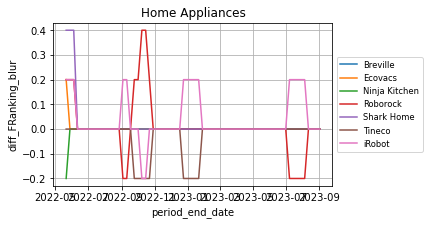

In [13]:
# Some compset_groups to visualize the results
selection_of_cgroups=['Luxury & Premium & Mainstream', 'Apparel Retail','Home Appliances']

for cgroup in selection_of_cgroups:
    # finding peaks in the data (rolling mean of the change in follower ranking)
    peaks = {}
    peak_height = {}
    peak_time = {}
    for brand, data in cgroup_ranking[cgroup].groupby('business_entity_doing_business_as_name'):
        peaks[brand], _ = find_peaks(list(data['diff_FRanking_blur']), height=2)
        peak_height[brand] = np.array(data['diff_FRanking_blur'])[peaks[brand]]
        peak_time[brand] = np.array(data['period_end_date'])[peaks[brand]]
        
    all=np.concatenate(list(peak_height.values()))
    threshold = 2
    
    # Plotting each brand within the respective compset group. The rolling mean of the change in follower ranking is plotted against time.
    plt.figure(figsize=(5,3))
    for brand, data in cgroup_ranking[cgroup].groupby('business_entity_doing_business_as_name'):
        plt.plot(data['period_end_date'], data['diff_FRanking_blur'], label=brand)
        # Find outliers within the peaks
        if len(peak_time[brand])>0:
            z_scores = (peak_height[brand] - np.mean(all)) / np.std(all)
            if len(peak_time[brand][np.abs(z_scores) > threshold])>0:
                plt.plot(peak_time[brand][np.abs(z_scores) > threshold], peak_height[brand][np.abs(z_scores) > threshold], 'ko', markersize=10, label=f'Outlier ({brand})')
    plt.xlabel('period_end_date')
    plt.ylabel('diff_FRanking_blur')
    plt.title(cgroup)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', ncol=math.ceil(len(brands_by_cgroup[cgroup])/30))
    plt.grid(True)
    plt.show()

### Correlation Analysis

Calculating the Correlation of different variables for different time shifts proved to be of significant help when trying to detect outliers. They Form a Metric for quantifying how much the data within one compset group deviates from the rest

In [14]:
import math
brands_by_cgroup = {} # dict: list of brands contained in each compset_group
for group in compset_groups:
    brands_by_cgroup[group] = df_brands[df_brands['compset_group'] == group][
        'business_entity_doing_business_as_name'].tolist()

cgroup_ranking = {cgroup: df_rate[df_rate['business_entity_doing_business_as_name'].isin(brands_by_cgroup[cgroup])] for cgroup in compset_groups}
compset_groups = df_brands['compset_group'].unique()

#initialize an array to save the correlation values
app_ret_correlation = []
df_corr = pd.DataFrame()
cgroup = 'Outdoor Gear' #in this example we look at companies producing Outdoor gear

for brand, data in cgroup_ranking[cgroup].groupby('business_entity_doing_business_as_name'):
    app_ret_correlation = []
    for lag in range(-8, 8):
        app_ret_correlation.append(data['change in likes'].corr(data['change in followers'].shift(lag)))
    
    # Create a temporary DataFrame for the current brand
    df_brand = pd.DataFrame({
        'correlation': app_ret_correlation,
        'lag': np.arange(-8, 8),
        'brand': brand
    })
    
    # Append the data for the current brand to the main DataFrame
    df_corr = pd.concat([df_corr, df_brand], ignore_index=True)

#normalize the curves by dividing by the mean correlation and looking whether the curve deviates significantly by 1
df_corr_normalized = df_corr.copy()
# Calculate the mean correlation for each lag across all companies
mean_corrs = df_corr.groupby('lag')['correlation'].mean()
# Normalize and shift the correlation values for each company
for brand in df_corr_normalized['brand'].unique():
    for lag in df_corr_normalized['lag'].unique():
        # Normalize the correlation values by the mean correlation for the lag across all companies
        df_corr_normalized.loc[(df_corr_normalized['lag'] == lag) & (df_corr_normalized['brand'] == brand), 'correlation'] /= mean_corrs[lag]
    # Shift the correlation values by their own mean to center them around y = 0
    df_corr_normalized.loc[df_corr_normalized['brand'] == brand, 'correlation'] -= df_corr_normalized.loc[df_corr_normalized['brand'] == brand, 'correlation'].mean()
    
from scipy.ndimage import gaussian_filter1d

sigma = 2
# Create a copy of the DataFrame for smoothed values
df_corr_smoothed = df_corr_normalized.copy()

# Smooth the correlation values for each brand separately
for brand in df_corr_normalized['brand'].unique():
    # Extract correlation values for the current brand
    brand_data = df_corr_normalized[df_corr_normalized['brand'] == brand]
    # Smooth the correlation values using Gaussian filter
    smoothed_values = gaussian_filter1d(brand_data['correlation'], sigma)
    # Update the DataFrame with the smoothed values
    df_corr_smoothed.loc[df_corr_smoothed['brand'] == brand, 'correlation'] = smoothed_values

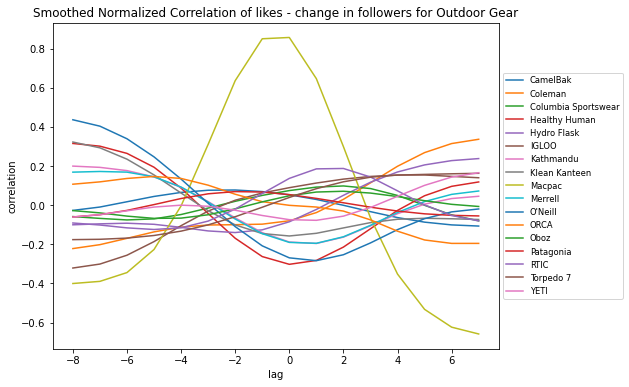

In [15]:
#the comparatevily strong correlation of company macpac around a lag of -1 indicates that for a week with strong likes, their followers increase in week + 1 predictably
plt.figure(figsize=(8,6))
for brand in df_corr_smoothed['brand'].unique():
    plt.plot(range(-8,8), df_corr_smoothed.loc[df_corr_smoothed['brand'] == brand, 'correlation'], label = brand)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', ncol=math.ceil(len(brands_by_cgroup[cgroup])/30))
plt.title('Smoothed Normalized Correlation of likes - change in followers for Outdoor Gear')
plt.xlabel('lag')
plt.ylabel('correlation')
plt.show()

## 2. Development of Model

### 2.1 Model Describtion
All the models are implemented based on `tensorflow.keras.Model`, together with related function, packed in the python file `model.py`. 

**Goal: make predictions for furture weeks**

*Input*: 
    - df : dataframe : the first derivatives (change) of the features, ['followers', 'likes', 'comments', 'videos', 'figures'], which are the difference between two weeks. 
    - pred_step : int : the number of future weeks we want to make predictions. 
*Output*: the predicted change of features for the future weeks.

- Baseline model: Start with a model that repeats the last input time step. 
- RepeatBaseline: Just return the current step input; The above two are used as a performance baseline for comparison with more colplicated models;
- Single-shot model:
- Linear model: one layer transformation between the input and output;
- Dense model: add dense layers between the input and output giving the linear model more power;
- Convolution Neural Network: one convolution layer;
- Recurrent Neural Network: one LSTM layer, one Dense layer;
- Autoregressive model: using the lower leverl layer `tf.keras.layers.LSTMCell` directly.
   

### 2.2 Running Models

In [ ]:
# import models from python file
from model import *
from utilities import *

In [ ]:
# Load the dataframe
df = clean_data()[0]
# get the first derivative of the data
df = derivatives_data(df)[0]
# for fast running, drop all missing data
df.dropna(inplace=True)
# Get any brands you want to make predictions
# e.g get the top-10 brands with the most data
brands = df['business_entity_doing_business_as_name'].value_counts().index[:10]

Training model for Harry Winston (1/10)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3875 - mean_absolute_error: 0.4417 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7341 - mean_absolute_error: 0.6607 
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8637 - mean_absolute_error: 0.7342 - val_loss: 0.8683 - val_mean_absolute_error: 0.7628
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8224 - mean_absolute_error: 0.7153 - val_loss: 0.8359 - val_mean_absolute_error: 0.7493
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7908 - mean_absolute_error: 0.7000 - val_loss: 0.8057 - val_mean_absolute_error: 0.7359
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7660 - mean_absolute_error: 0.6863 - val_loss: 0.7770 - val_mean_absolute_error: 0.7227
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7340 - mean_absolute_error: 0.6733 - val_loss: 0.7498 - val_mean_absolute_error: 0.7100
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

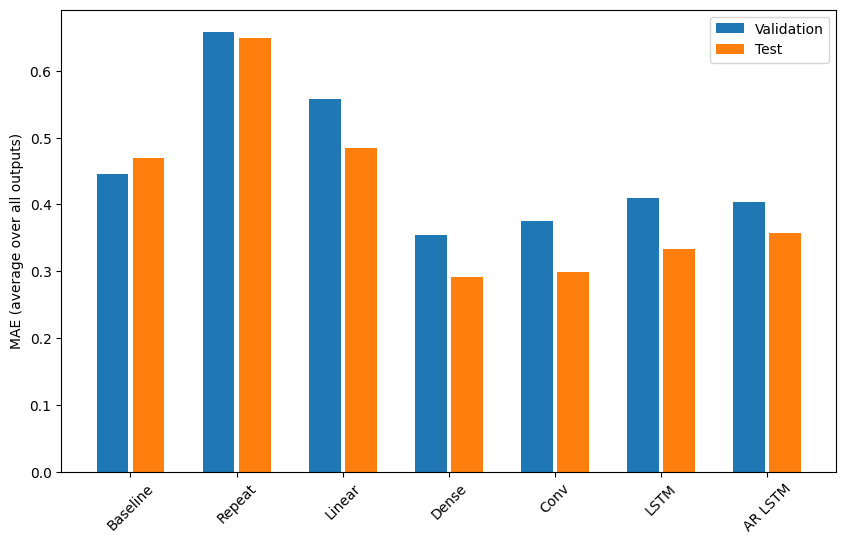

Baseline       : 0.4693
Repeat         : 0.6496
Linear         : 0.4846
Dense          : 0.2913
Conv           : 0.2995
LSTM           : 0.3330
AR LSTM        : 0.3567


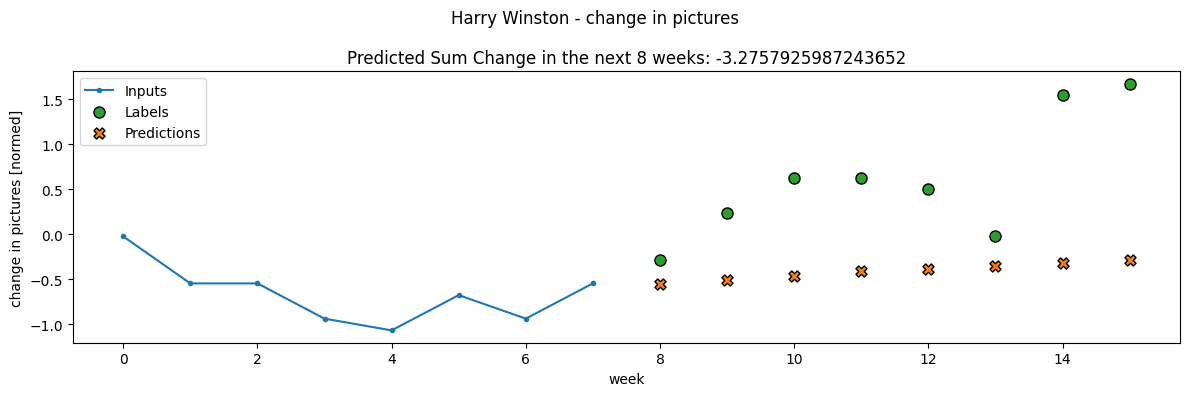

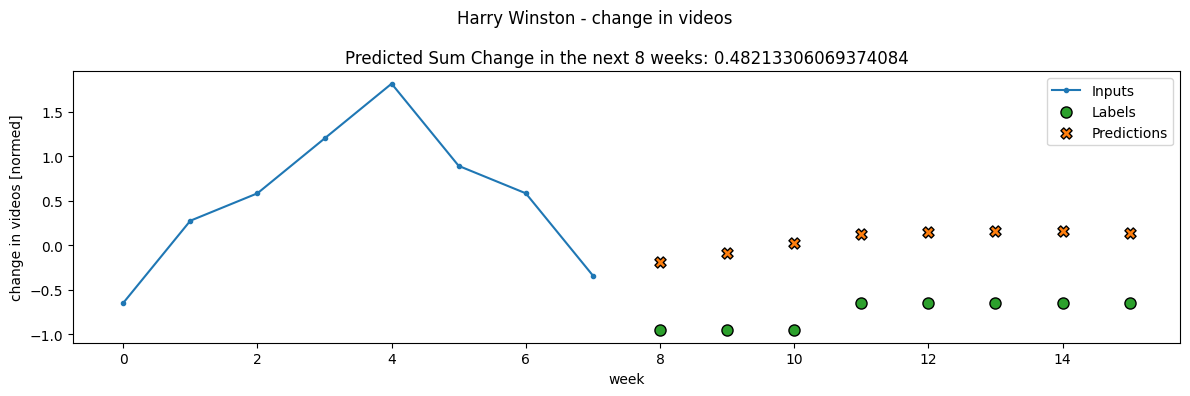

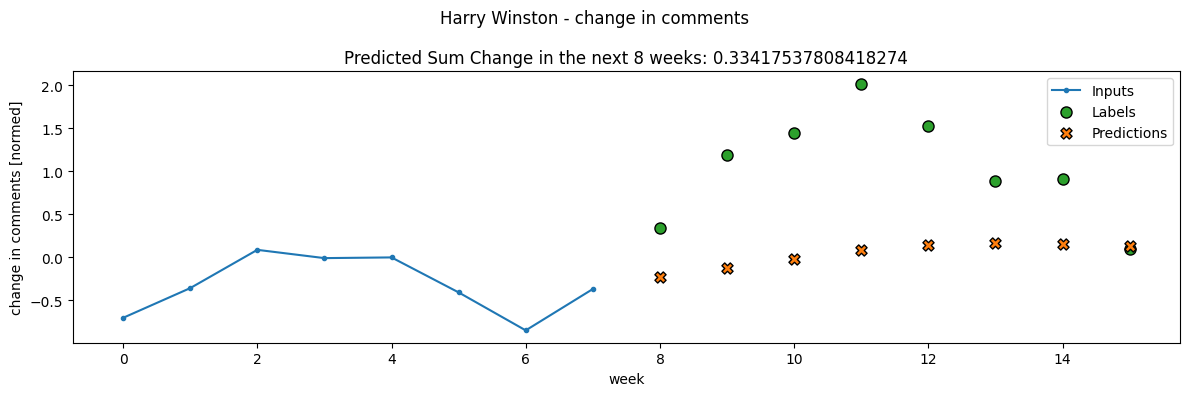

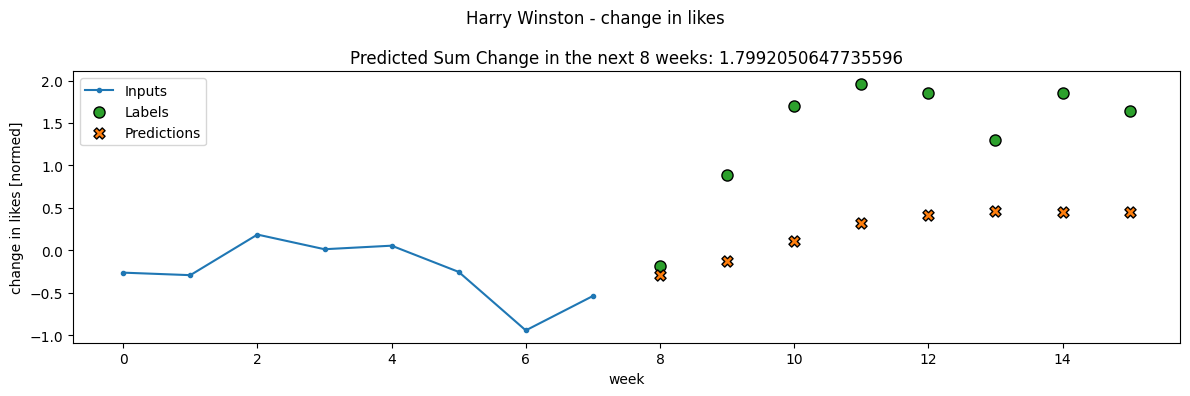

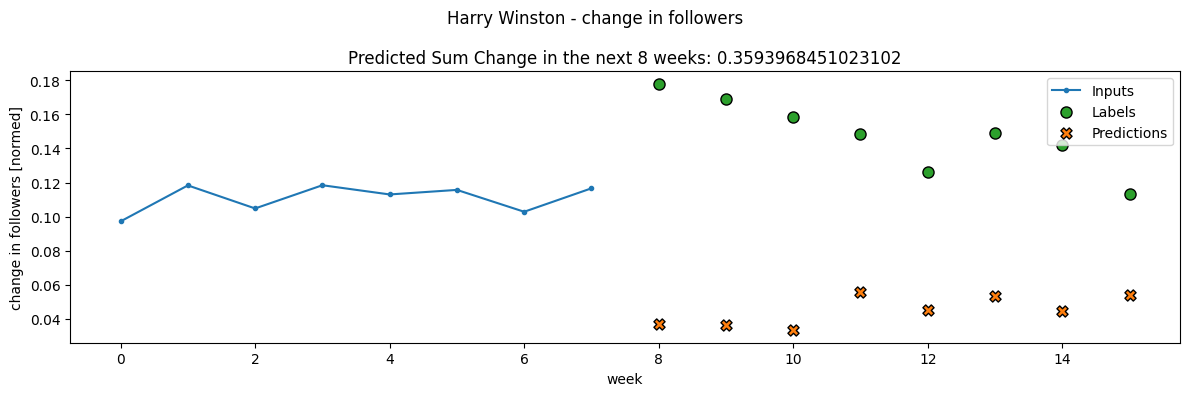

Training model for Saks Fifth Avenue (2/10)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 0.2501 - mean_absolute_error: 0.3352
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4927 - mean_absolute_error: 0.5140 
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8680 - mean_absolute_error: 0.7064 - val_loss: 0.7750 - val_mean_absolute_error: 0.7035
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8564 - mean_absolute_error: 0.6953 - val_loss: 0.7470 - val_mean_absolute_error: 0.6901
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8247 - mean_absolute_error: 0.6842 - val_loss: 0.7205 - val_mean_absolute_error: 0.6773
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7405 - mean_absolute_error: 0.6501 - val_loss: 0.6959 - val_mean_absolute_error: 0.6651
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7517 - mean_absolute_error: 0.6469 - val_loss: 0.6724 - val_mean_absolute_error: 0.6530
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

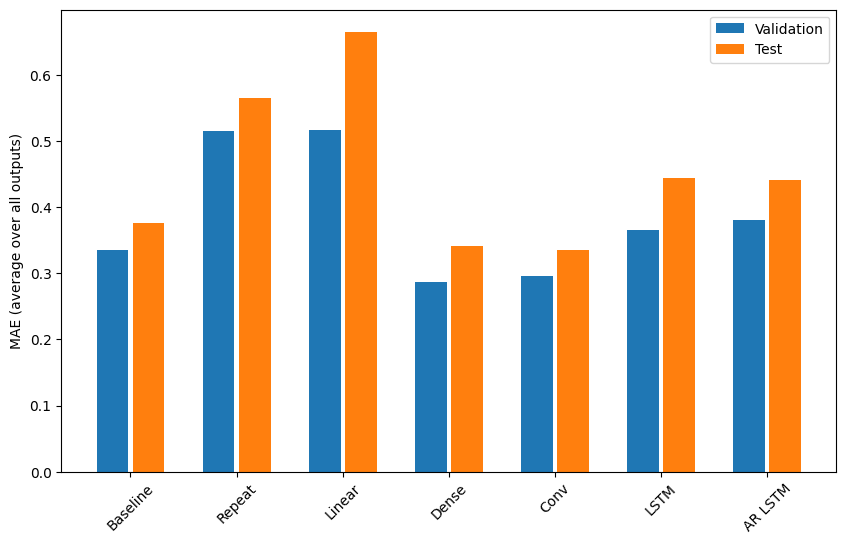

Baseline       : 0.3765
Repeat         : 0.5658
Linear         : 0.6658
Dense          : 0.3415
Conv           : 0.3358
LSTM           : 0.4435
AR LSTM        : 0.4406


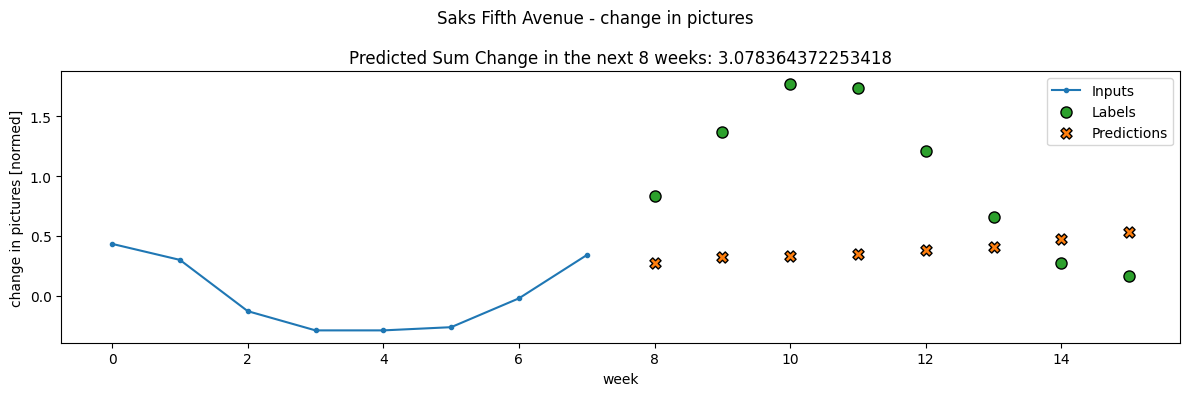

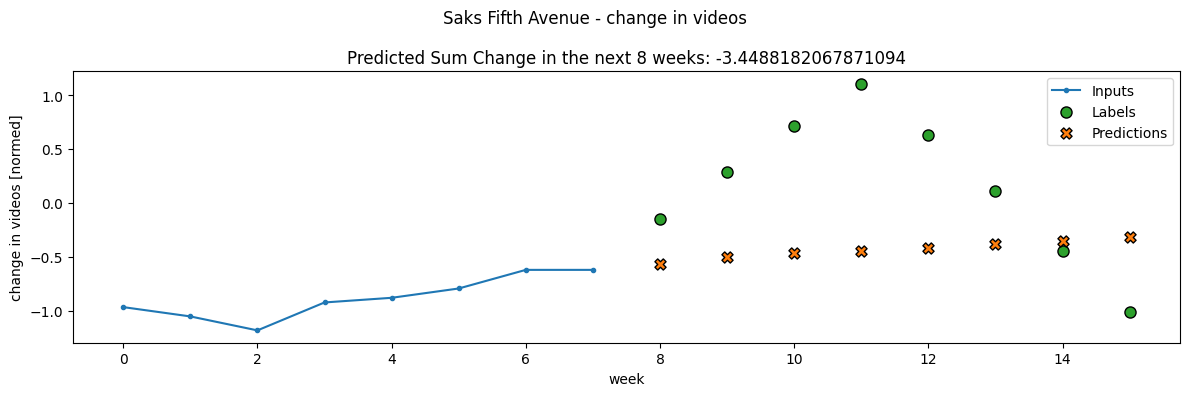

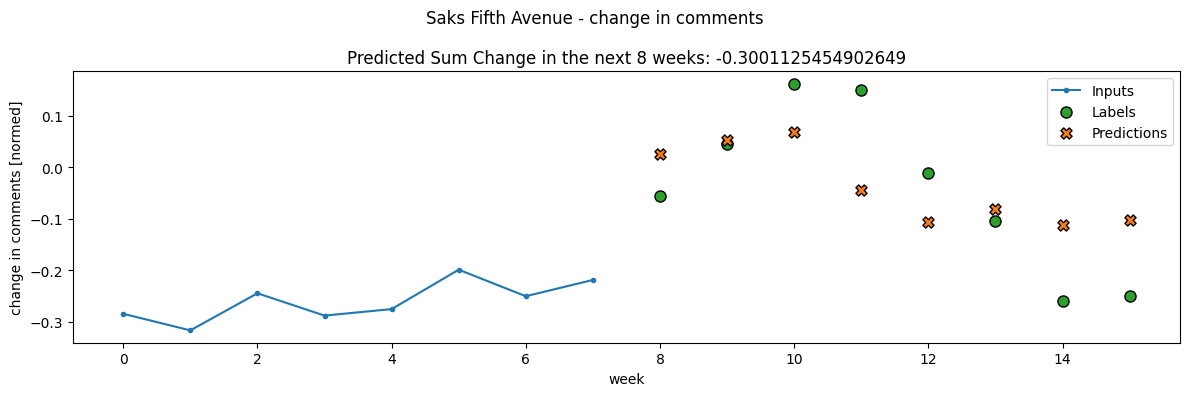

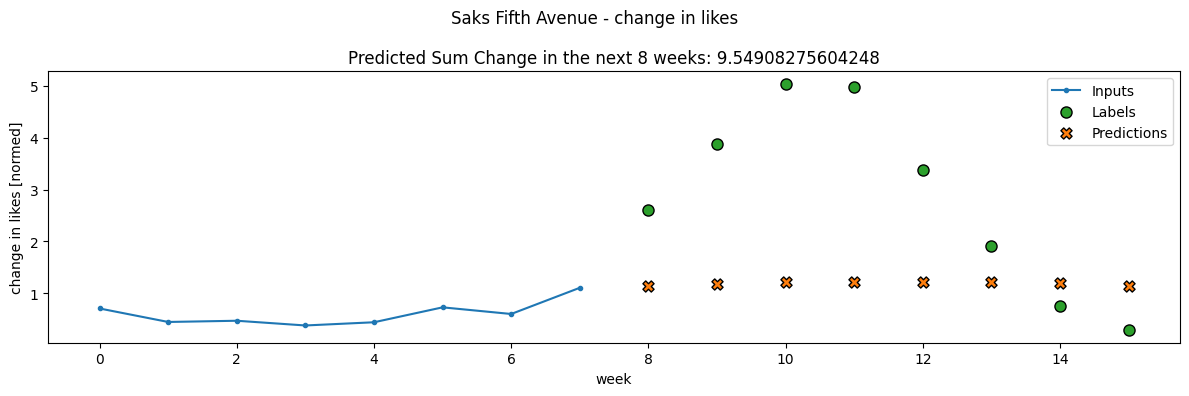

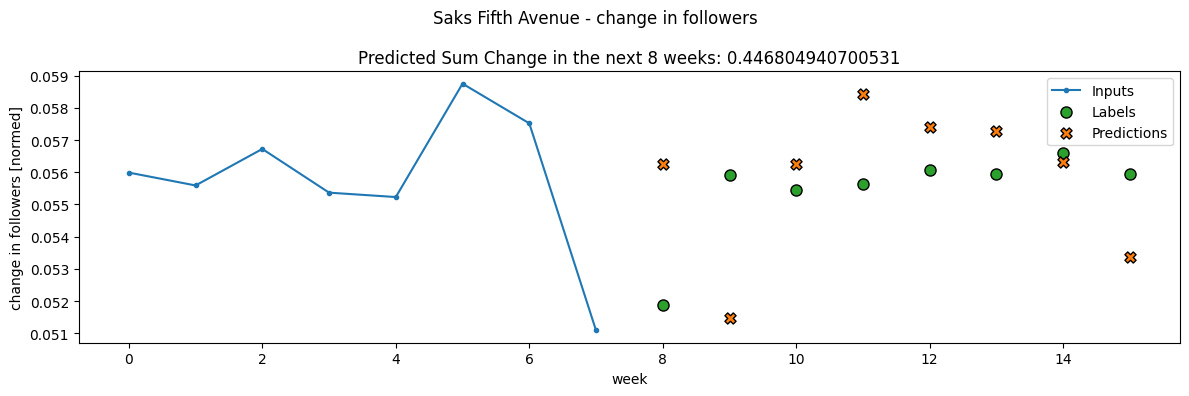

Training model for Dior (3/10)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 2.3640 - mean_absolute_error: 0.8163
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 3.2706 - mean_absolute_error: 1.1030
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8711 - mean_absolute_error: 0.7664 - val_loss: 3.0502 - val_mean_absolute_error: 1.0815
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8517 - mean_absolute_error: 0.7567 - val_loss: 2.9741 - val_mean_absolute_error: 1.0604
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7929 - mean_absolute_error: 0.7297 - val_loss: 2.9055 - val_mean_absolute_error: 1.0411
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7449 - mean_absolute_error: 0.7076 - val_loss: 2.8393 - val_mean_absolute_error: 1.0213
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7198 - mean_absolute_error: 0.6928 - val_loss: 2.7774 - val_mean_absolute_error: 1.0025
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7

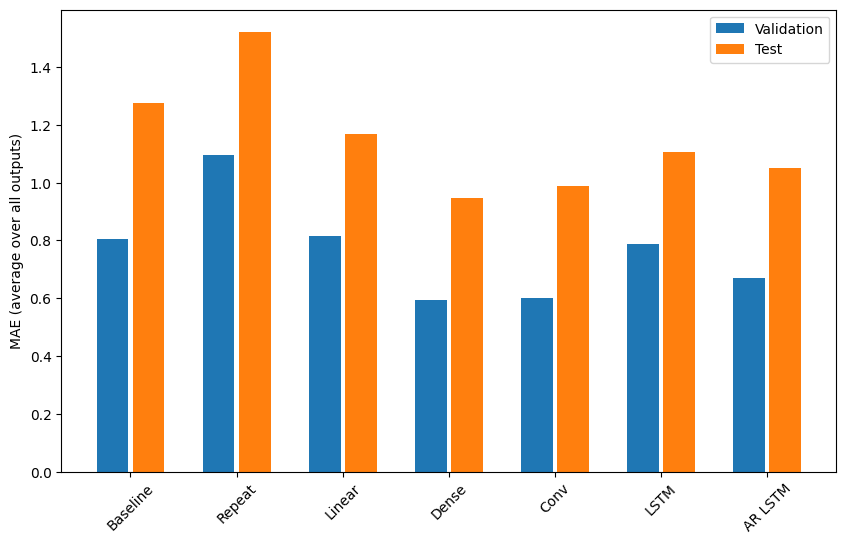

Baseline       : 1.2743
Repeat         : 1.5229
Linear         : 1.1682
Dense          : 0.9476
Conv           : 0.9881
LSTM           : 1.1065
AR LSTM        : 1.0524


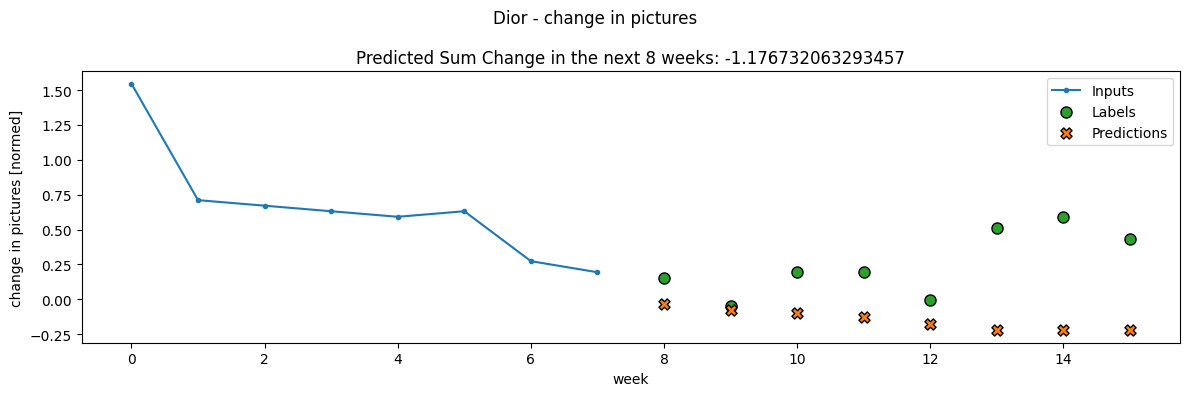

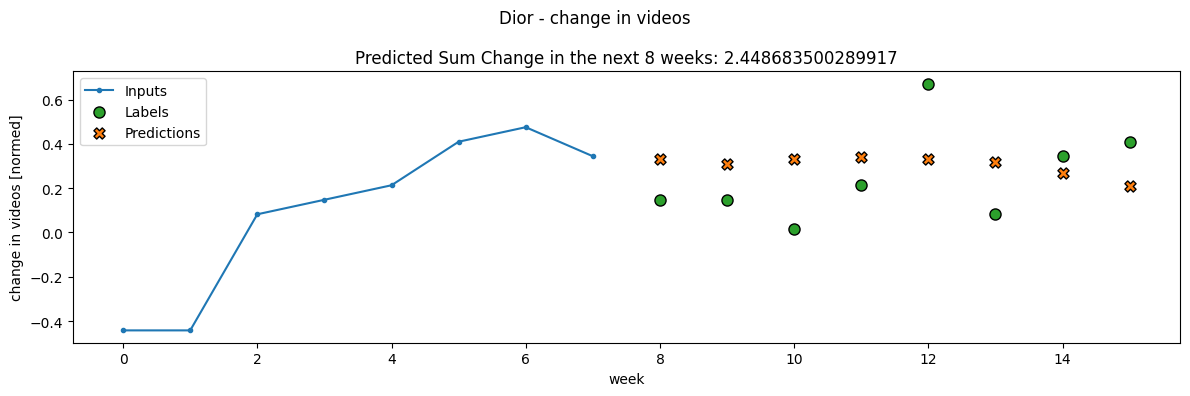

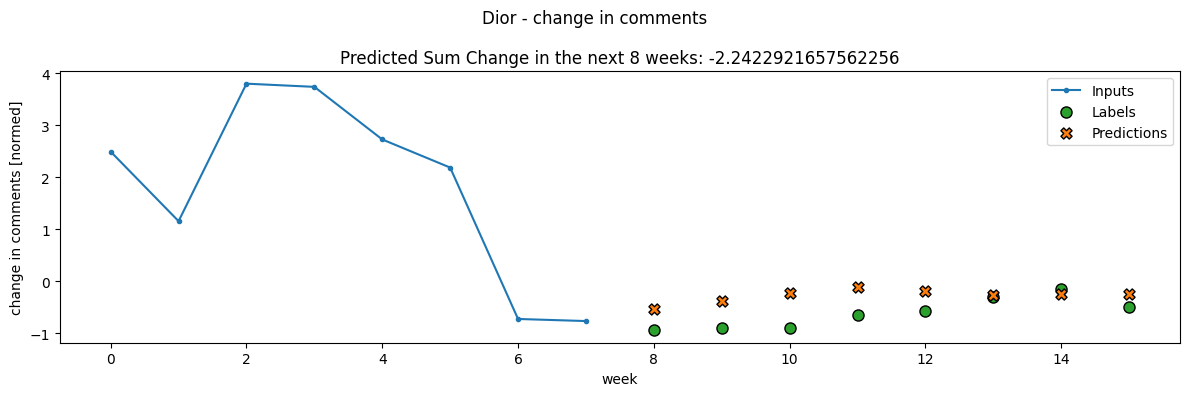

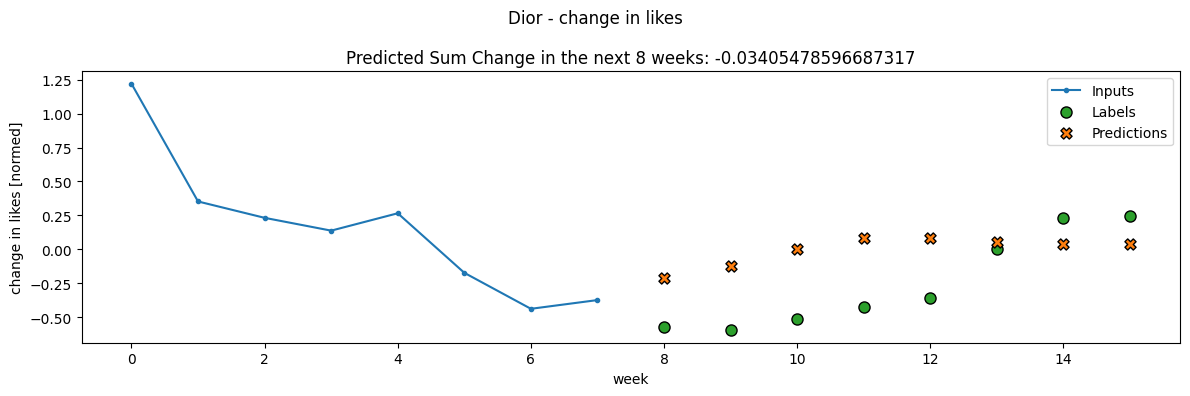

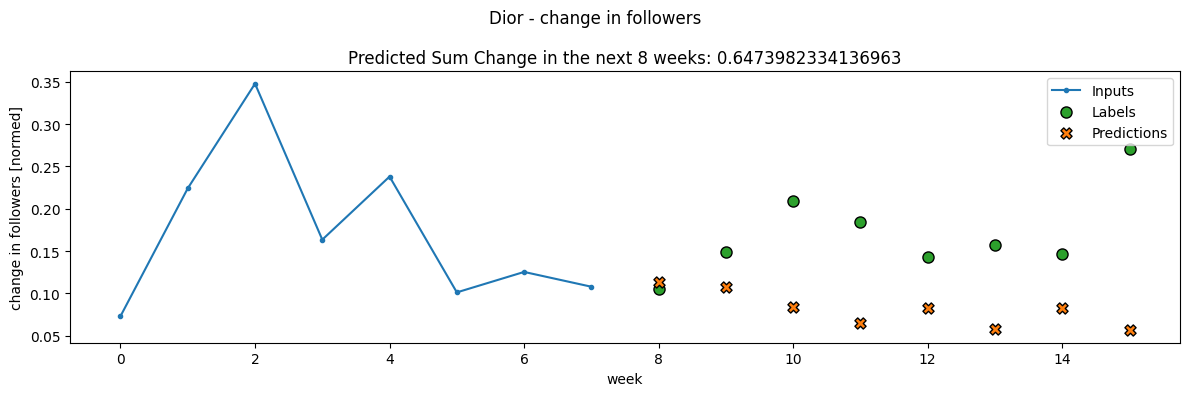

Training model for Omega (4/10)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 0.4208 - mean_absolute_error: 0.4604
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 0.6940 - mean_absolute_error: 0.6481
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9465 - mean_absolute_error: 0.8140 - val_loss: 0.7798 - val_mean_absolute_error: 0.7651
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9164 - mean_absolute_error: 0.8008 - val_loss: 0.7483 - val_mean_absolute_error: 0.7496
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8617 - mean_absolute_error: 0.7802 - val_loss: 0.7179 - val_mean_absolute_error: 0.7343
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8367 - mean_absolute_error: 0.7590 - val_loss: 0.6895 - val_mean_absolute_error: 0.7195
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7939 - mean_absolute_error: 0.7431 - val_loss: 0.6642 - val_mean_absolute_error: 0.7059
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

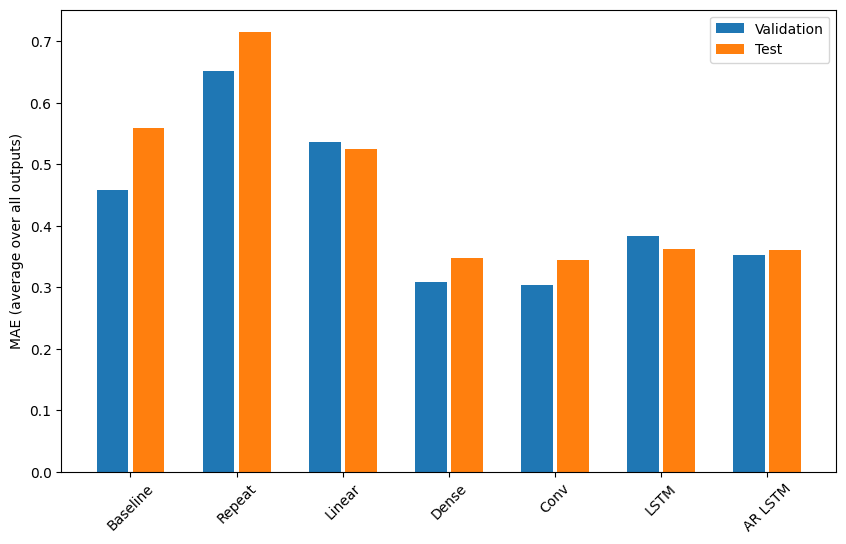

Baseline       : 0.5597
Repeat         : 0.7157
Linear         : 0.5254
Dense          : 0.3475
Conv           : 0.3436
LSTM           : 0.3627
AR LSTM        : 0.3599


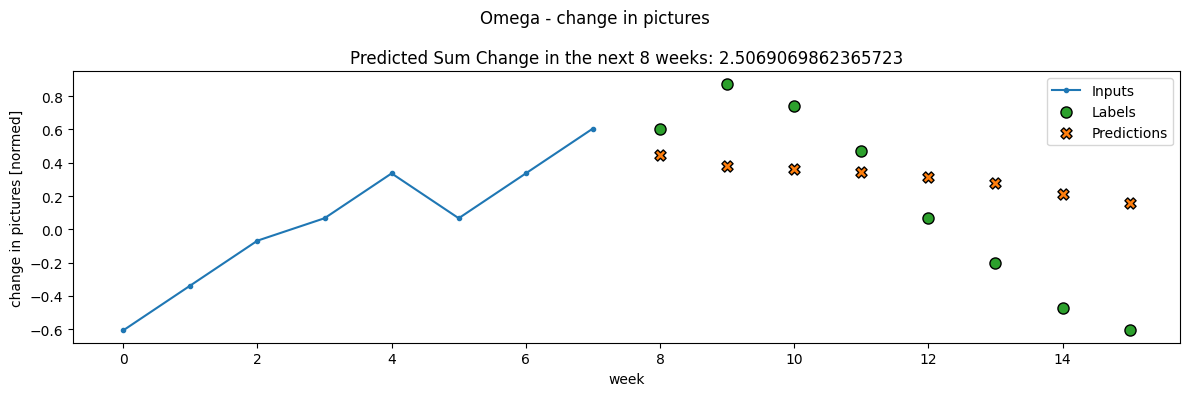

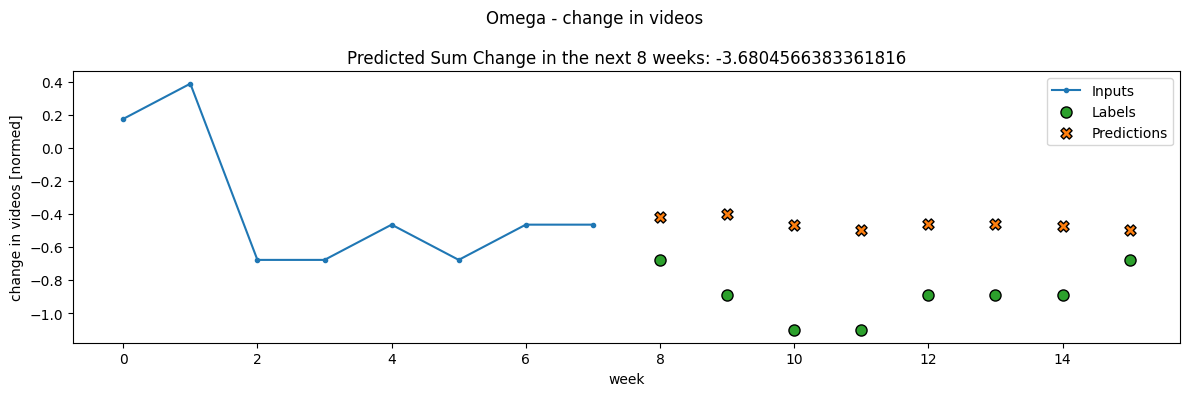

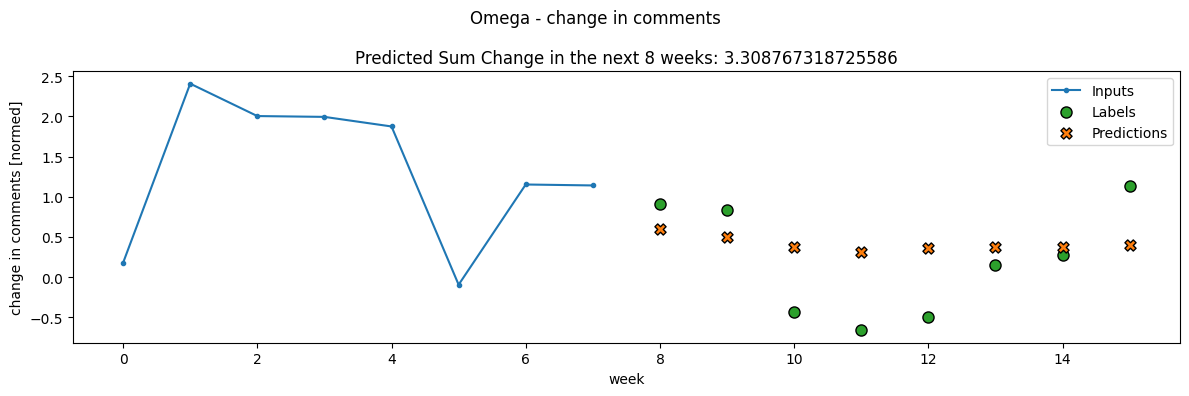

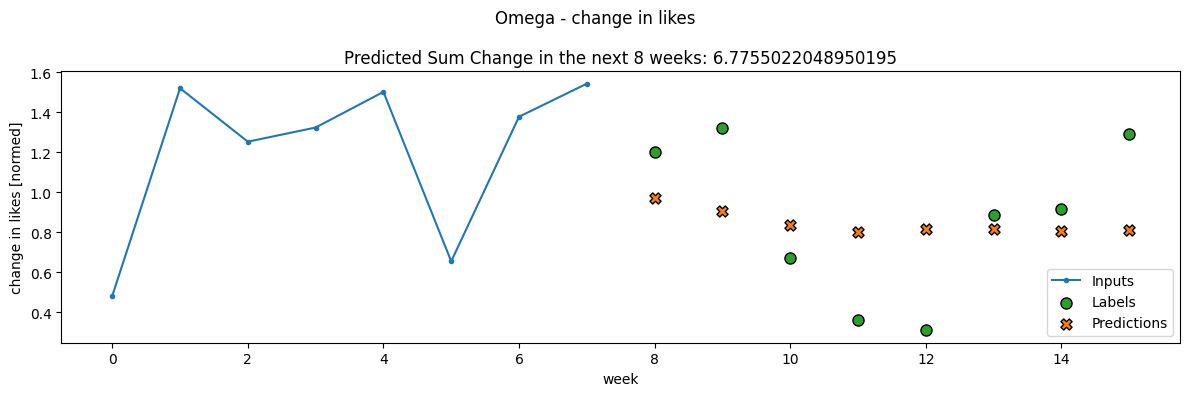

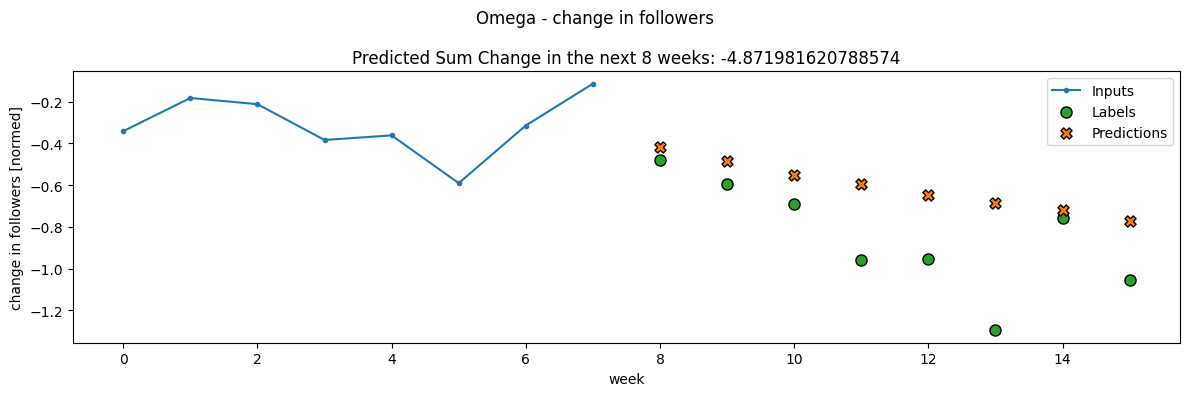

Training model for Sephora (5/10)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 0.5416 - mean_absolute_error: 0.4128
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 0.9153 - mean_absolute_error: 0.6208
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8393 - mean_absolute_error: 0.7430 - val_loss: 1.5612 - val_mean_absolute_error: 0.9194
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8247 - mean_absolute_error: 0.7368 - val_loss: 1.5258 - val_mean_absolute_error: 0.9048
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7483 - mean_absolute_error: 0.7023 - val_loss: 1.4922 - val_mean_absolute_error: 0.8910
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7167 - mean_absolute_error: 0.6890 - val_loss: 1.4606 - val_mean_absolute_error: 0.8776
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6395 - mean_absolute_error: 0.6482 - val_loss: 1.4296 - val_mean_absolute_error: 0.8645
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 

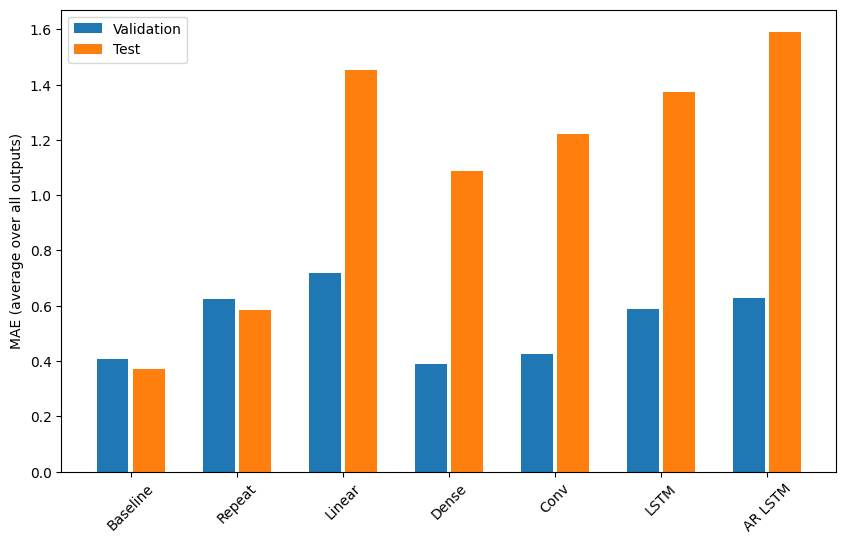

Baseline       : 0.3695
Repeat         : 0.5835
Linear         : 1.4522
Dense          : 1.0889
Conv           : 1.2207
LSTM           : 1.3744
AR LSTM        : 1.5918


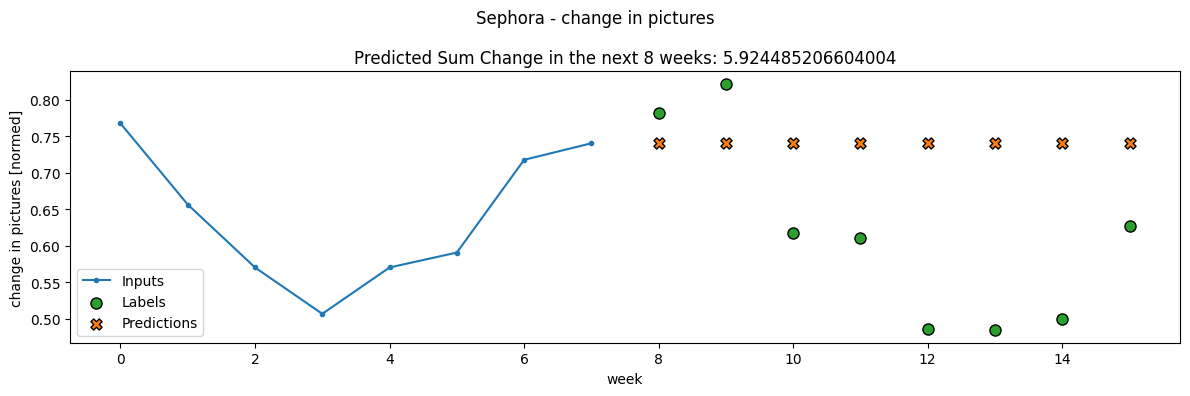

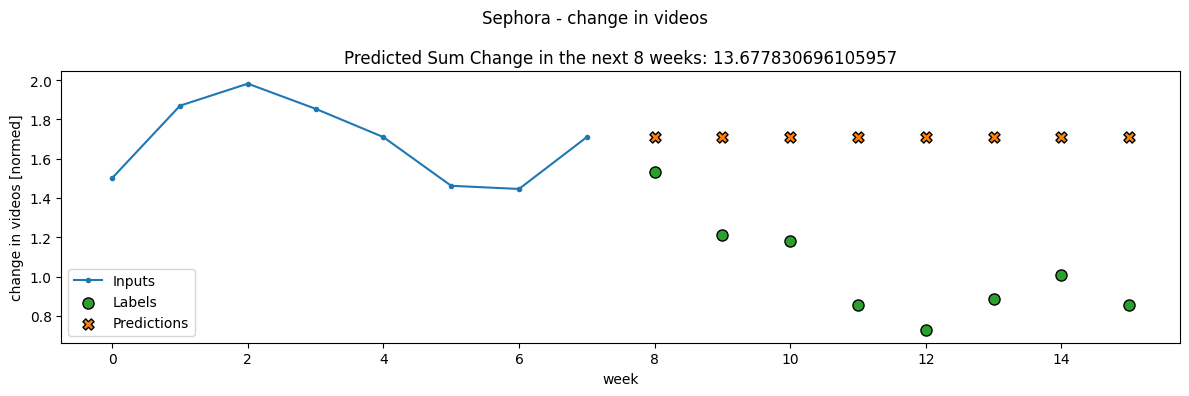

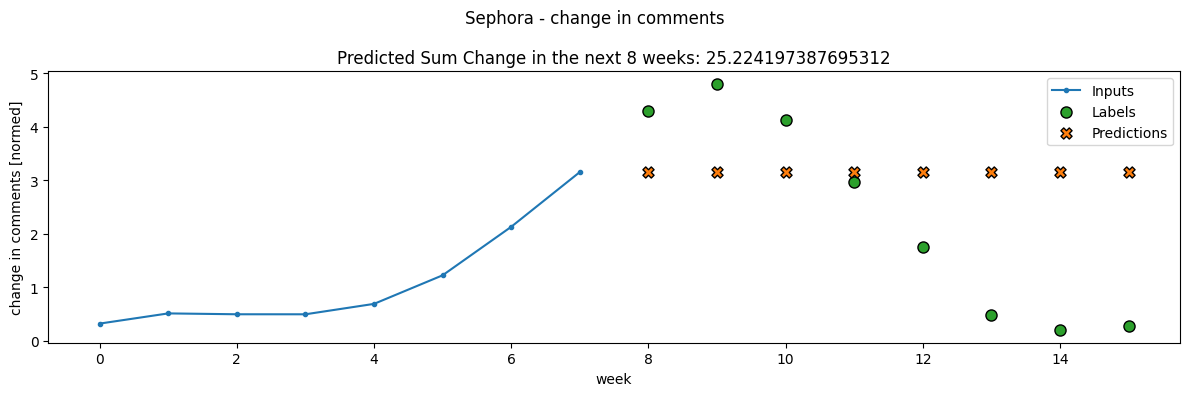

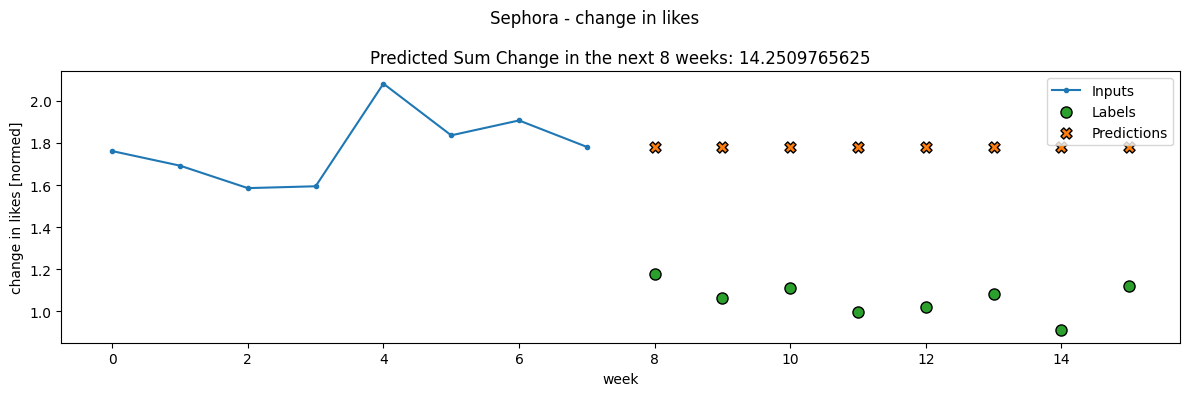

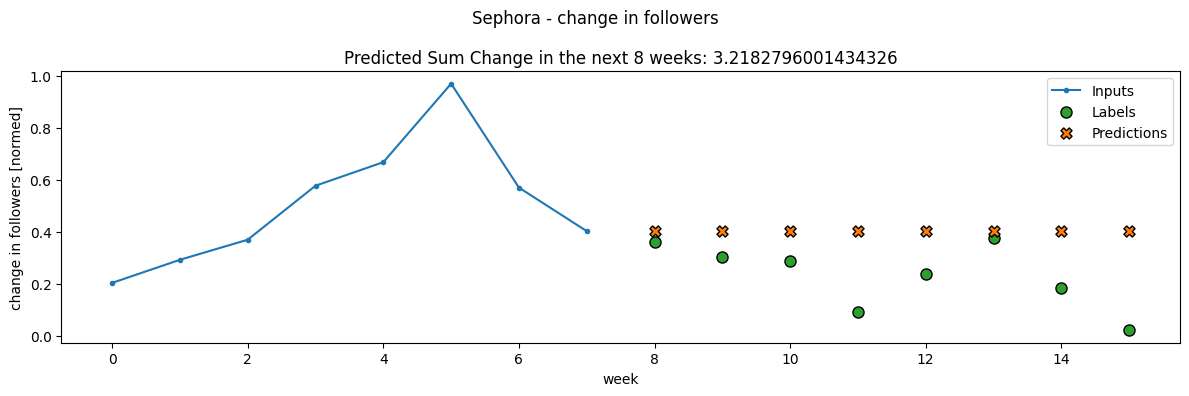

Training model for Coach (6/10)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4487 - mean_absolute_error: 0.4612 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 0.7731 - mean_absolute_error: 0.6762
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8651 - mean_absolute_error: 0.7320 - val_loss: 0.8152 - val_mean_absolute_error: 0.7385
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8239 - mean_absolute_error: 0.7128 - val_loss: 0.7877 - val_mean_absolute_error: 0.7240
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7651 - mean_absolute_error: 0.6926 - val_loss: 0.7621 - val_mean_absolute_error: 0.7097
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7555 - mean_absolute_error: 0.6824 - val_loss: 0.7381 - val_mean_absolute_error: 0.6963
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7394 - mean_absolute_error: 0.6697 - val_loss: 0.7158 - val_mean_absolute_error: 0.6838
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7

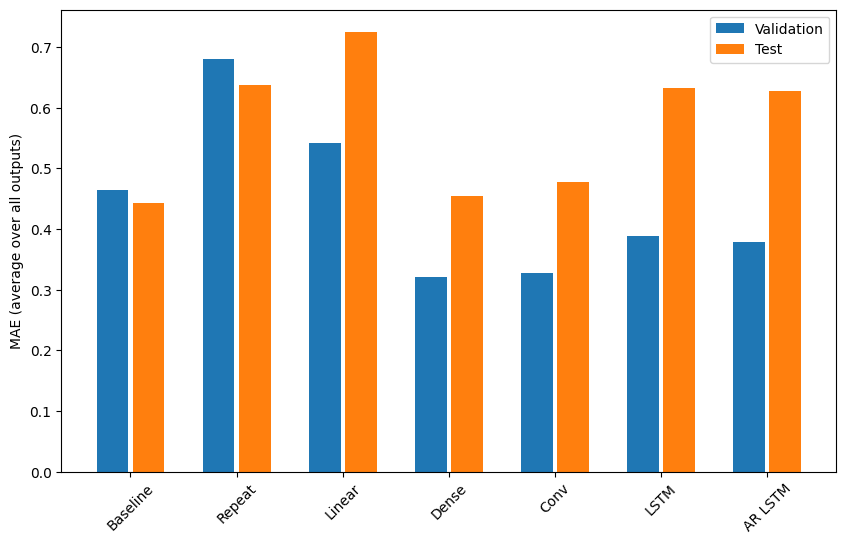

Baseline       : 0.4434
Repeat         : 0.6383
Linear         : 0.7255
Dense          : 0.4545
Conv           : 0.4782
LSTM           : 0.6327
AR LSTM        : 0.6269


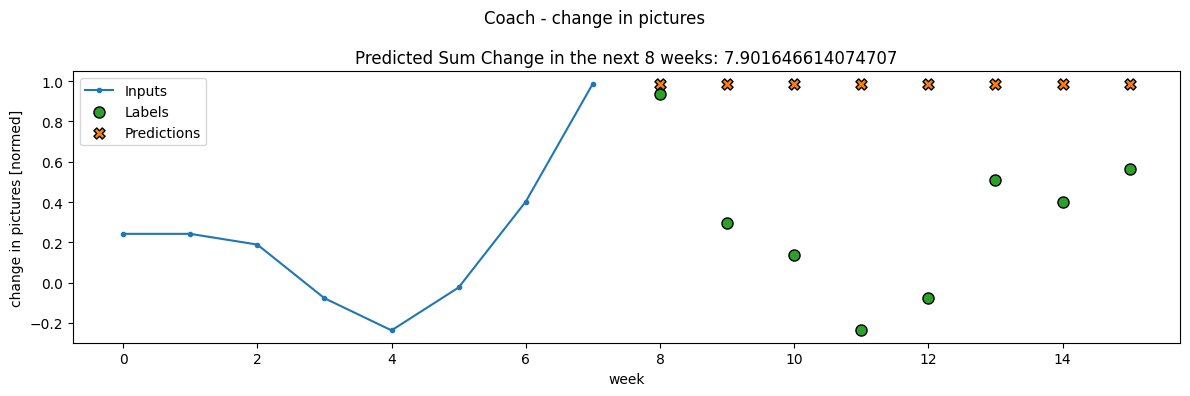

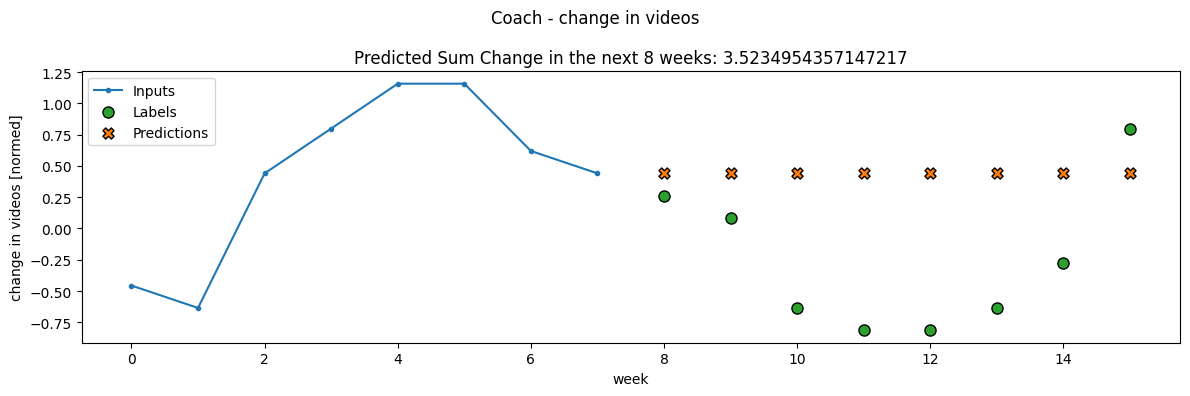

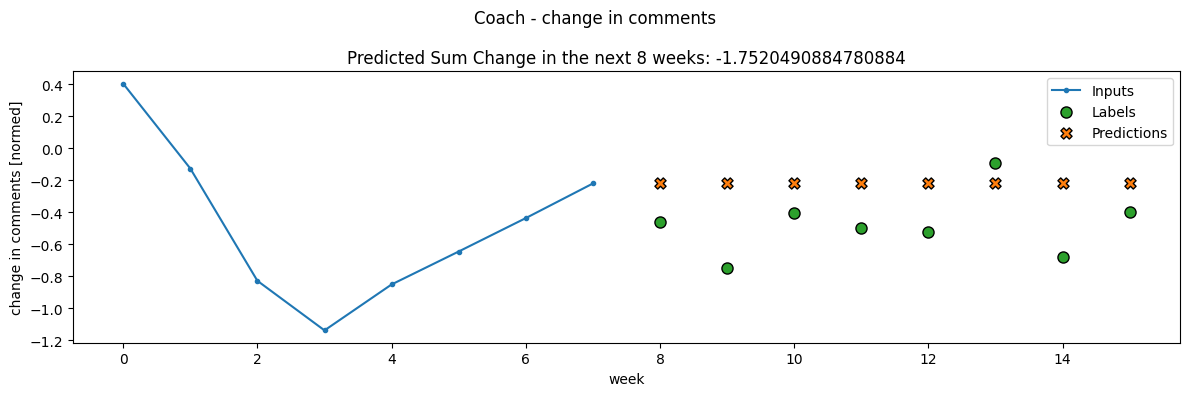

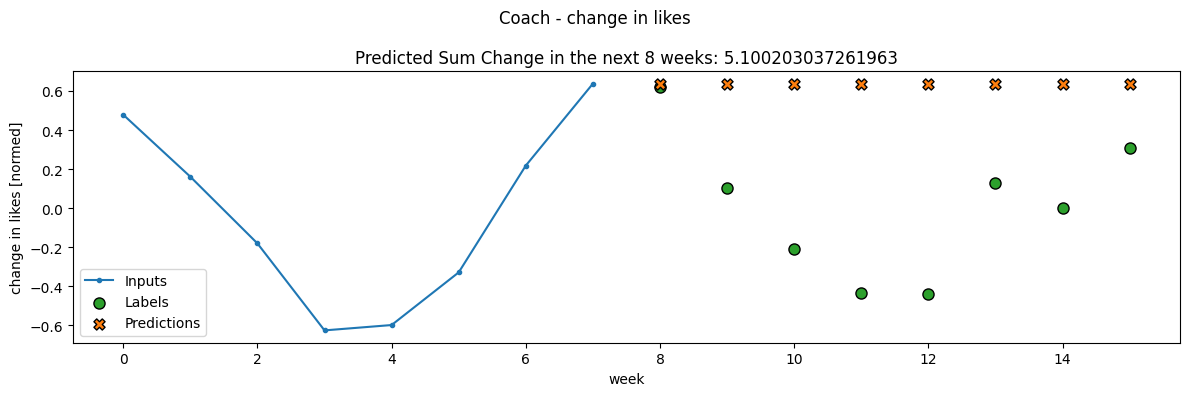

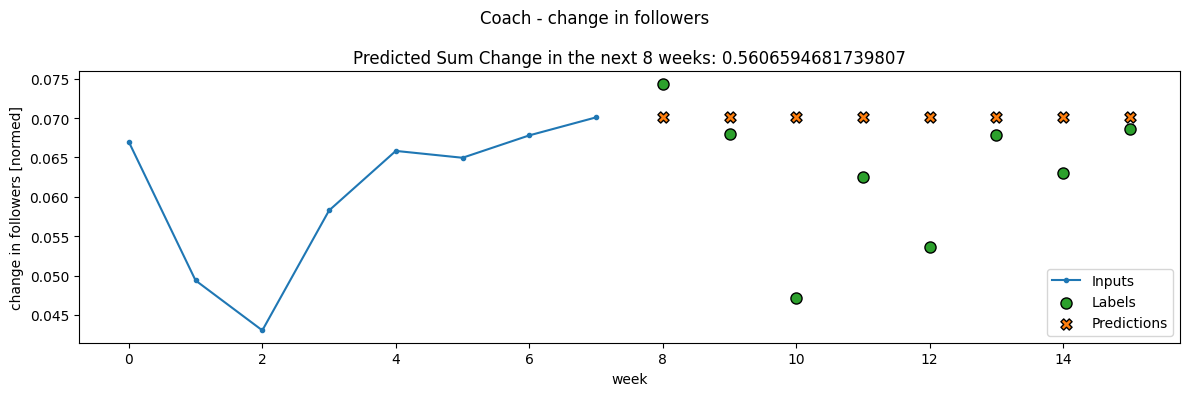

Training model for Chopard (7/10)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 2.1013 - mean_absolute_error: 0.7242
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 2.9333 - mean_absolute_error: 0.9782
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9708 - mean_absolute_error: 0.7095 - val_loss: 1.7376 - val_mean_absolute_error: 0.8281
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9009 - mean_absolute_error: 0.6839 - val_loss: 1.6974 - val_mean_absolute_error: 0.8145
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8877 - mean_absolute_error: 0.6723 - val_loss: 1.6608 - val_mean_absolute_error: 0.8017
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8838 - mean_absolute_error: 0.6711 - val_loss: 1.6275 - val_mean_absolute_error: 0.7894
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8317 - mean_absolute_error: 0.6478 - val_loss: 1.5976 - val_mean_absolute_error: 0.7780
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 

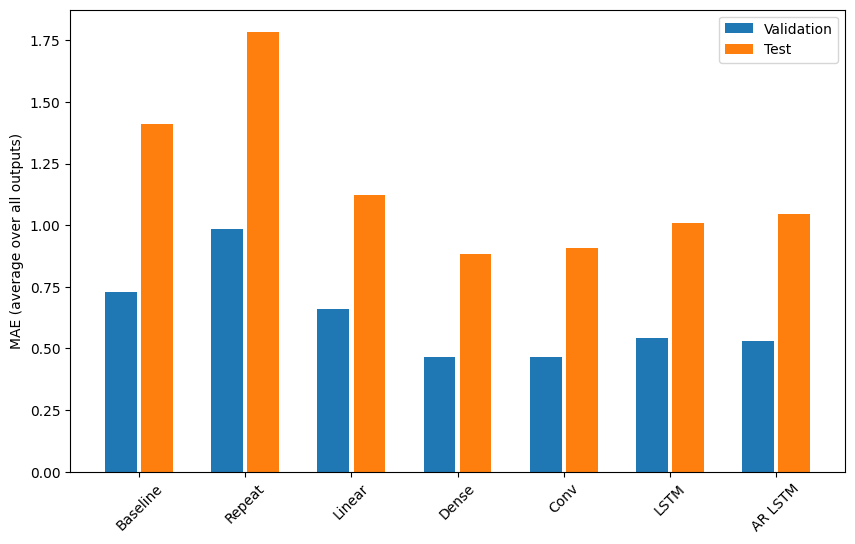

Baseline       : 1.4118
Repeat         : 1.7856
Linear         : 1.1216
Dense          : 0.8831
Conv           : 0.9072
LSTM           : 1.0102
AR LSTM        : 1.0468


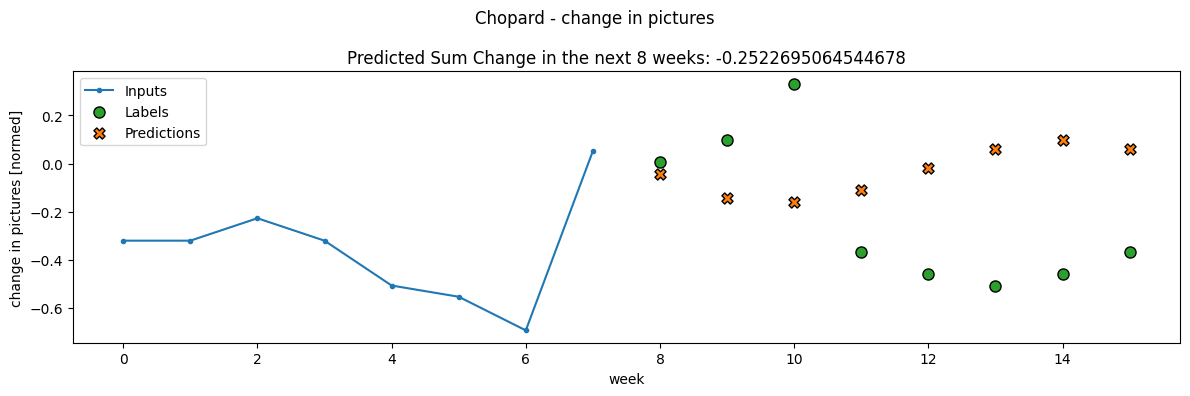

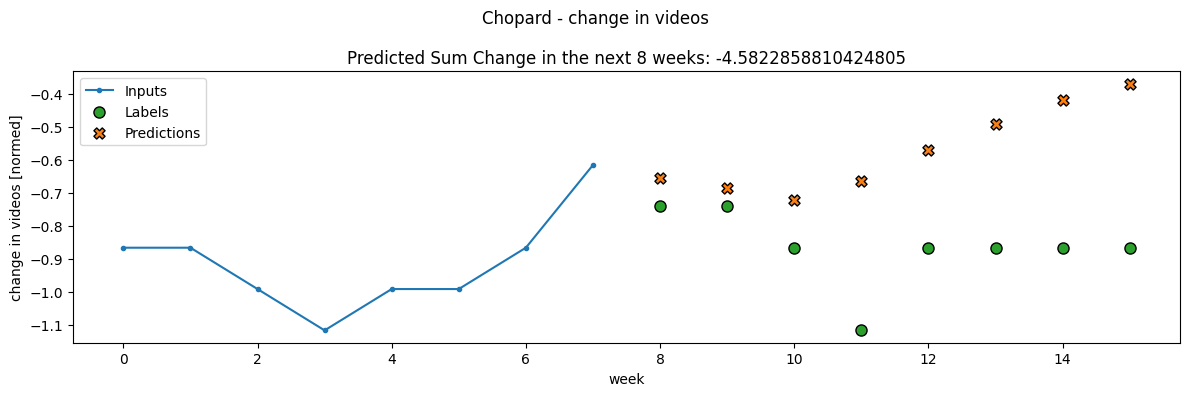

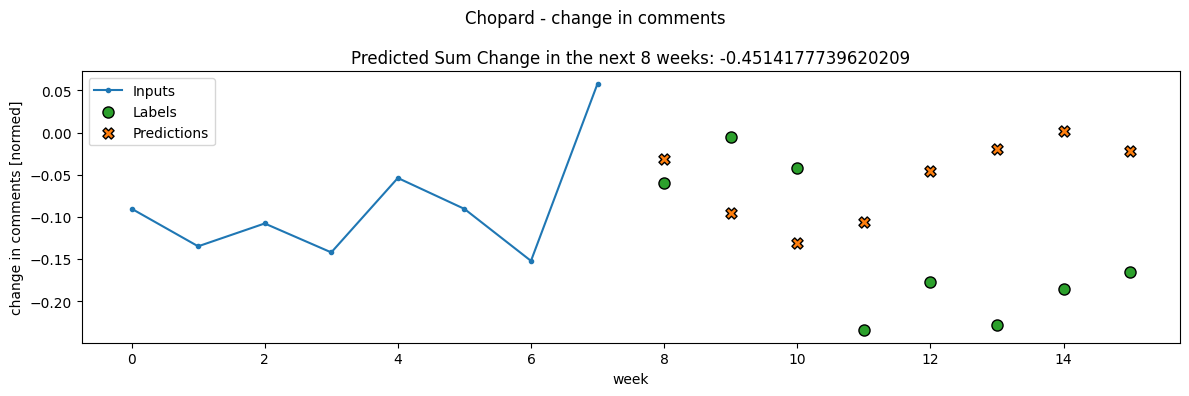

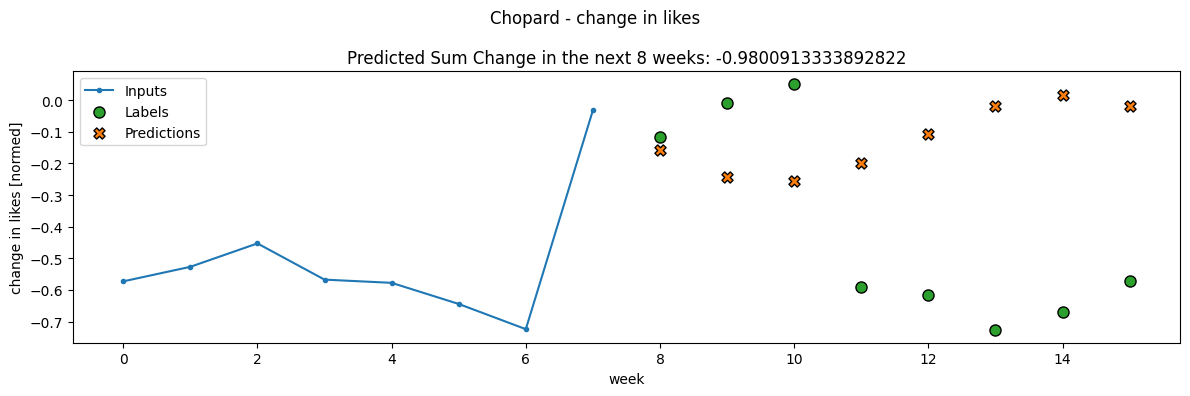

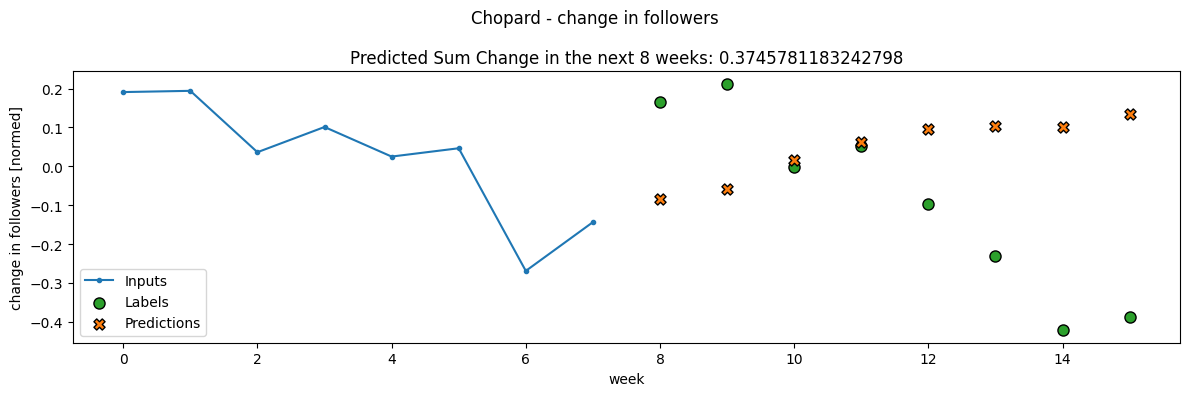

Training model for Chick-fil-A (8/10)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3210 - mean_absolute_error: 0.3912 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 0.6189 - mean_absolute_error: 0.6015
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8728 - mean_absolute_error: 0.7679 - val_loss: 0.6878 - val_mean_absolute_error: 0.6966
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8659 - mean_absolute_error: 0.7621 - val_loss: 0.6557 - val_mean_absolute_error: 0.6812
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8077 - mean_absolute_error: 0.7333 - val_loss: 0.6245 - val_mean_absolute_error: 0.6660
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7614 - mean_absolute_error: 0.7131 - val_loss: 0.5951 - val_mean_absolute_error: 0.6505
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7395 - mean_absolute_error: 0.7023 - val_loss: 0.5677 - val_mean_absolute_error: 0.6353
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - los

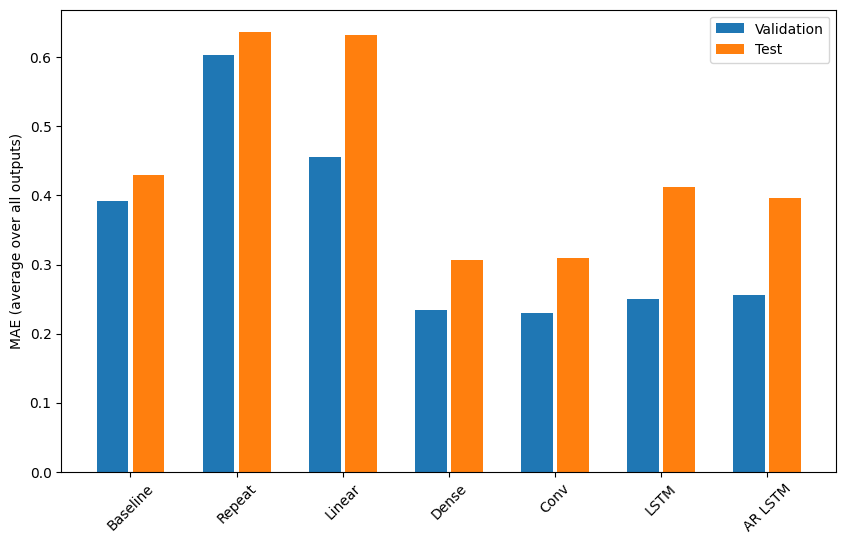

Baseline       : 0.4298
Repeat         : 0.6374
Linear         : 0.6325
Dense          : 0.3065
Conv           : 0.3092
LSTM           : 0.4121
AR LSTM        : 0.3969


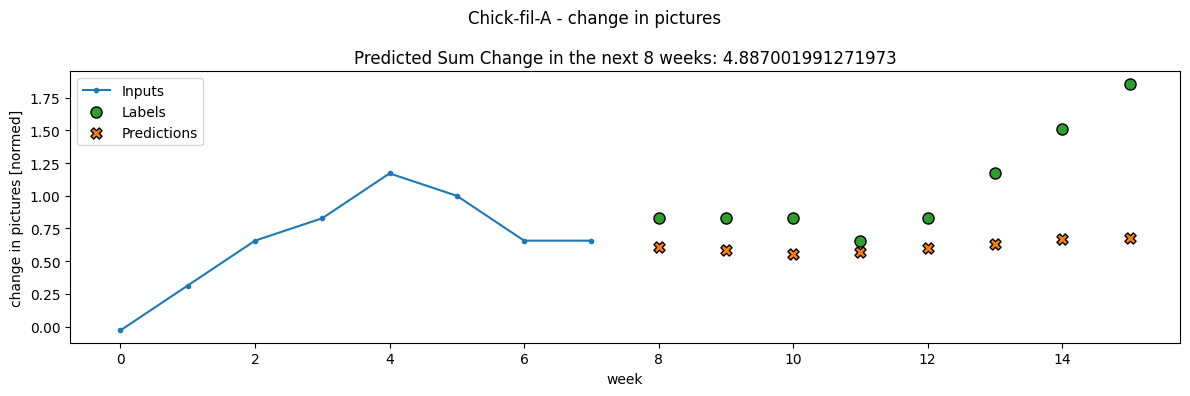

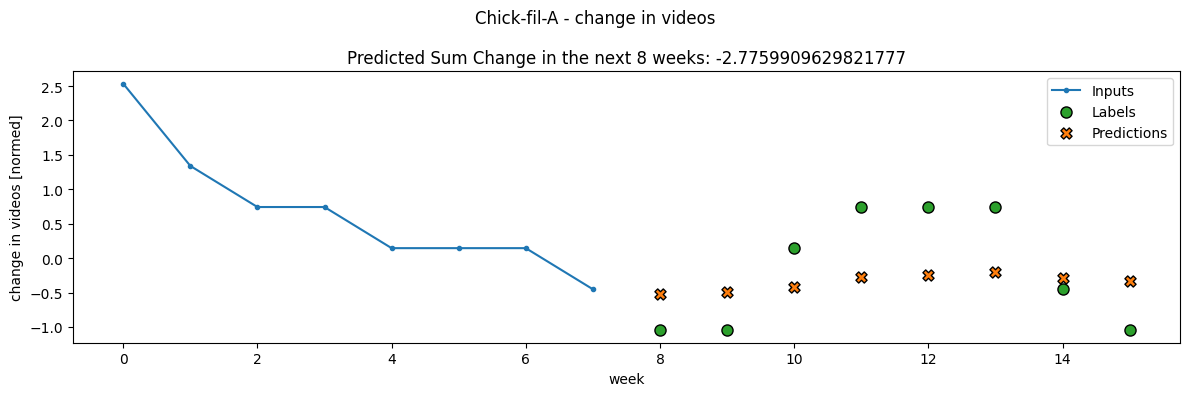

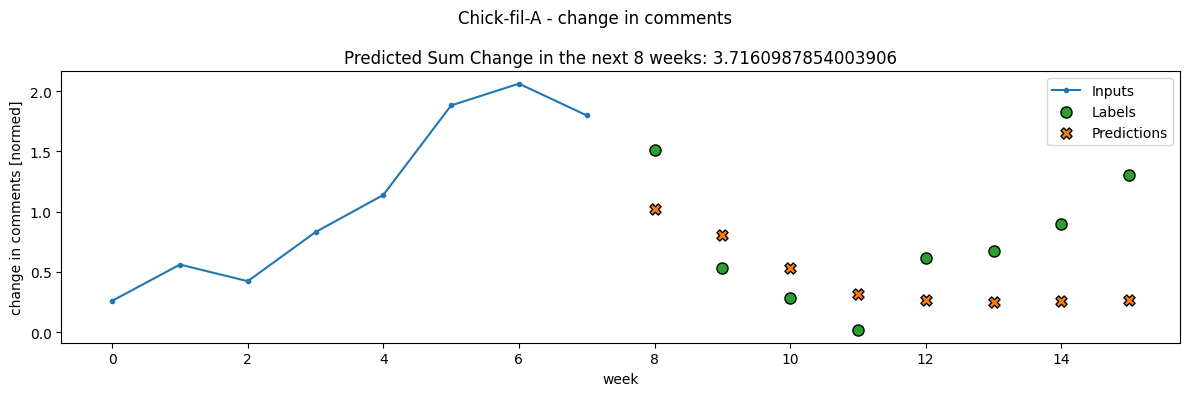

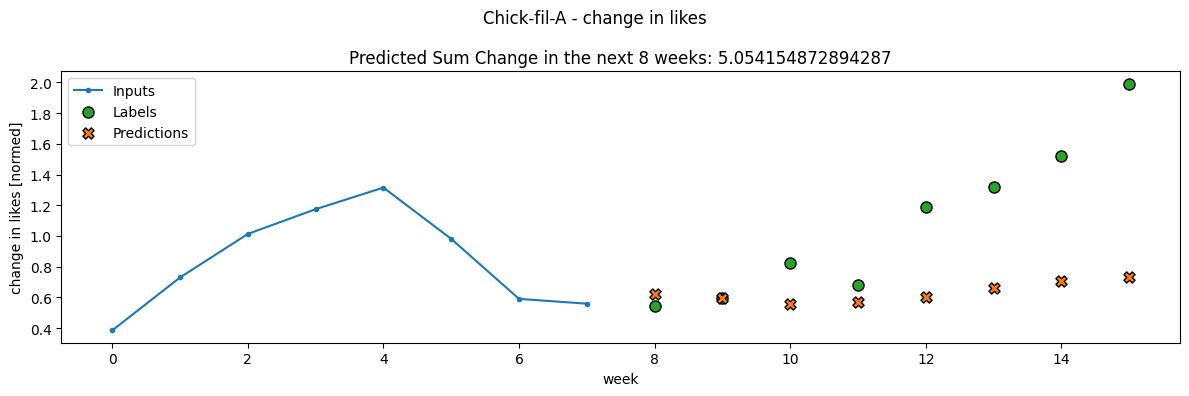

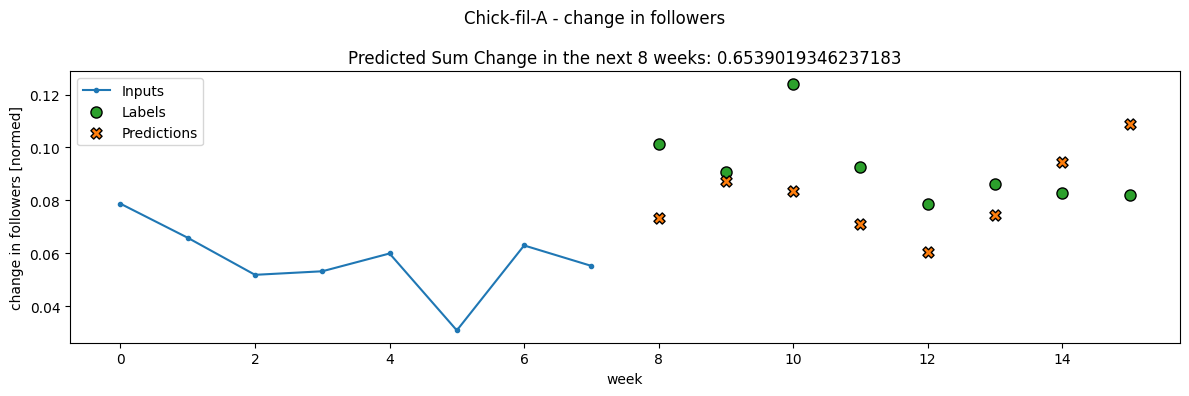

Training model for Champs Sports (9/10)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 1.3941 - mean_absolute_error: 0.4454
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 1.8896 - mean_absolute_error: 0.6610
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8757 - mean_absolute_error: 0.7511 - val_loss: 2.4672 - val_mean_absolute_error: 1.0817
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8359 - mean_absolute_error: 0.7312 - val_loss: 2.4304 - val_mean_absolute_error: 1.0697
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7919 - mean_absolute_error: 0.7085 - val_loss: 2.3955 - val_mean_absolute_error: 1.0579
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7401 - mean_absolute_error: 0.6817 - val_loss: 2.3625 - val_mean_absolute_error: 1.0462
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7078 - mean_absolute_error: 0.6696 - val_loss: 2.3316 - val_mean_absolute_error: 1.0360
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 

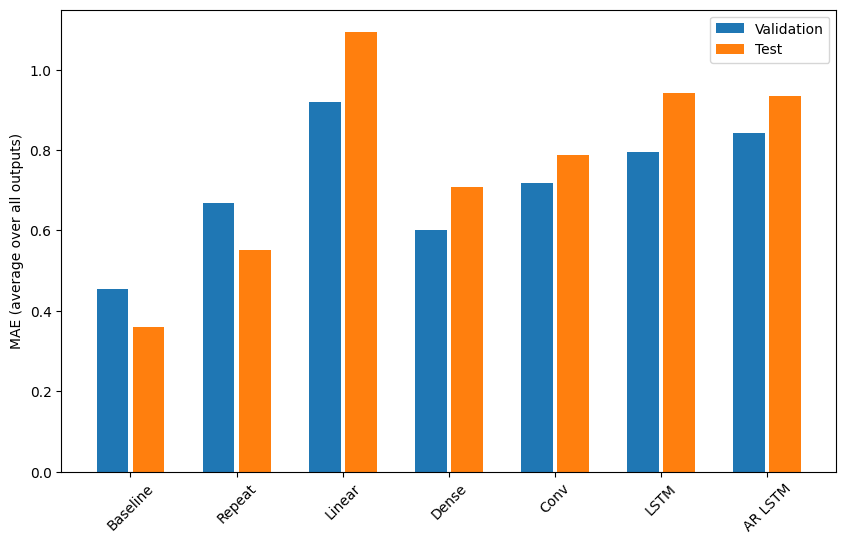

Baseline       : 0.3603
Repeat         : 0.5523
Linear         : 1.0950
Dense          : 0.7083
Conv           : 0.7882
LSTM           : 0.9420
AR LSTM        : 0.9349


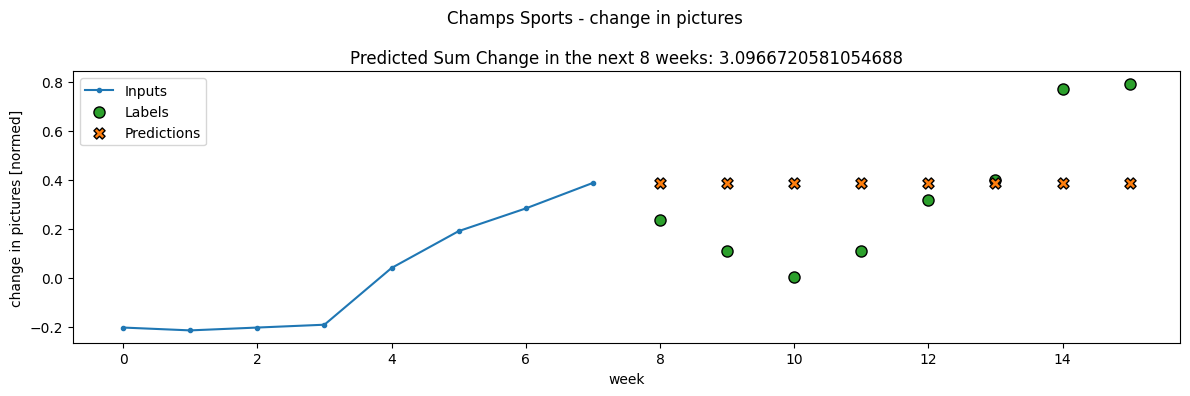

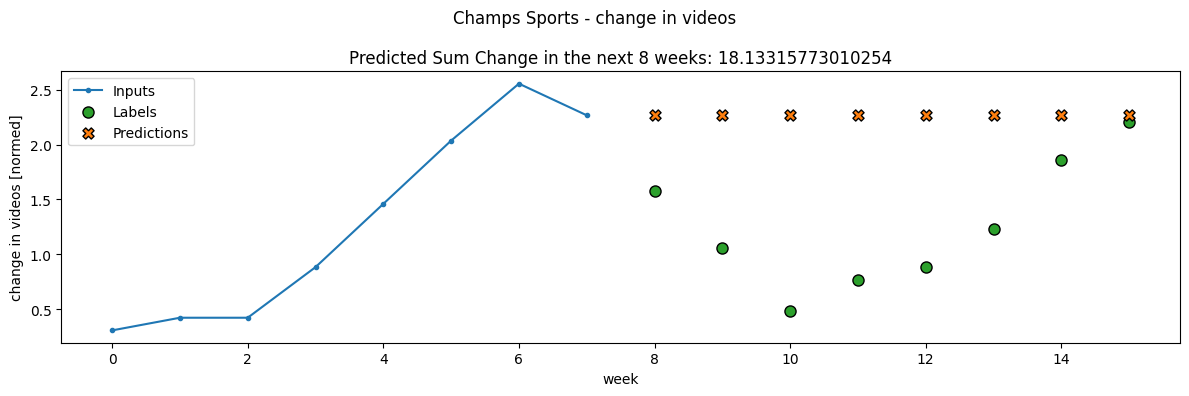

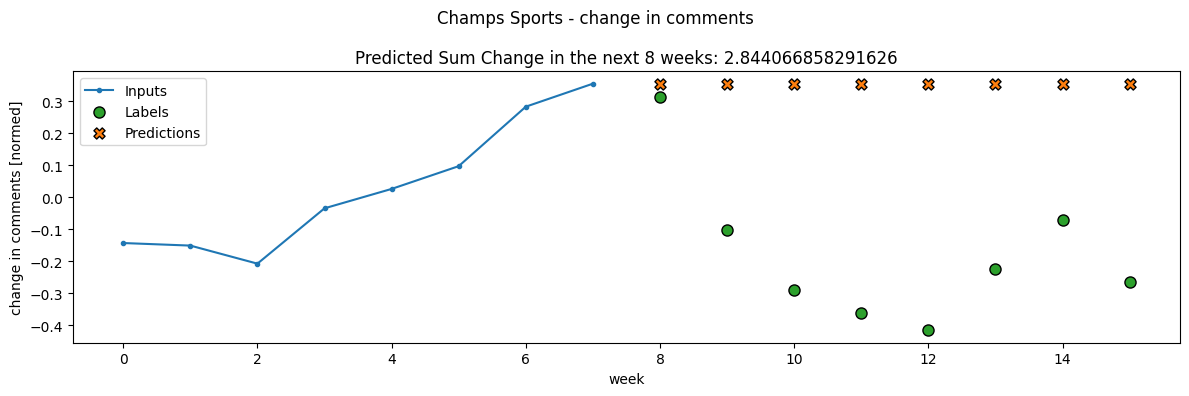

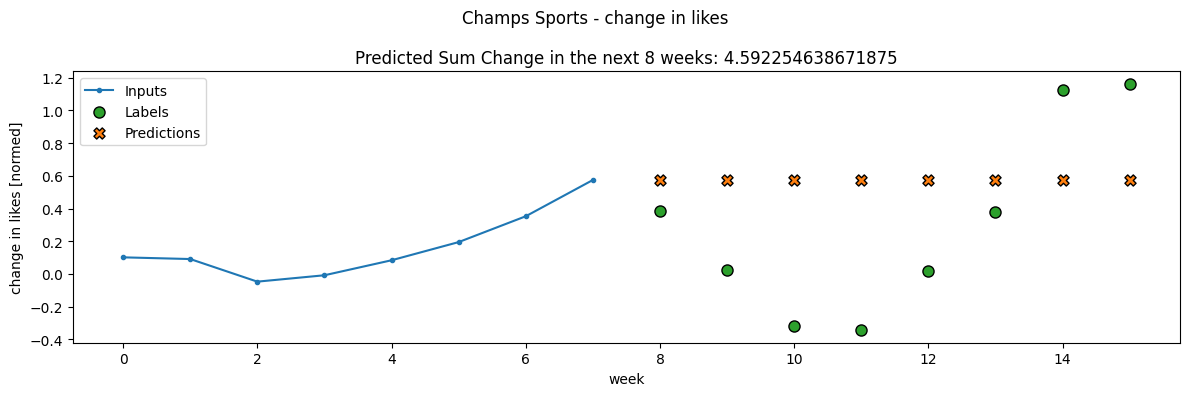

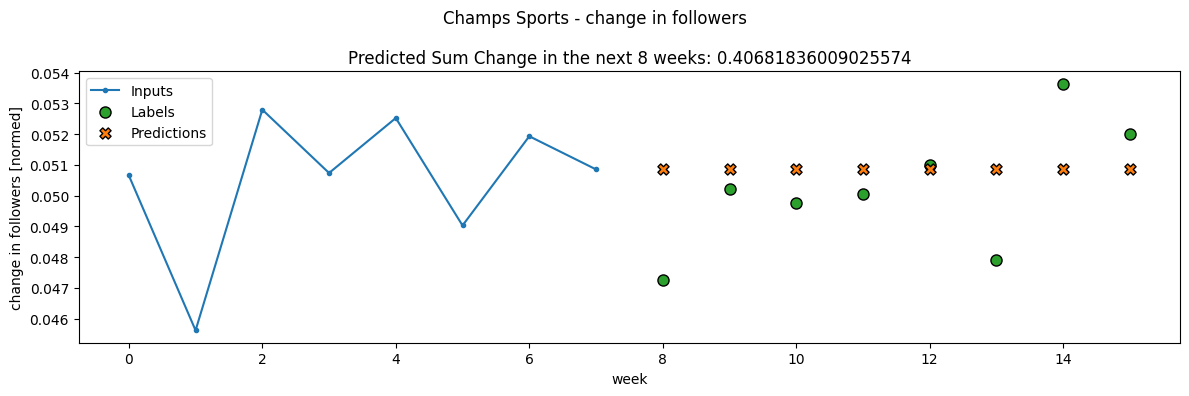

Training model for Prada (10/10)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 0.8391 - mean_absolute_error: 0.5743
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4498 - mean_absolute_error: 0.8364 
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8733 - mean_absolute_error: 0.7303 - val_loss: 1.0314 - val_mean_absolute_error: 0.7826
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8035 - mean_absolute_error: 0.7126 - val_loss: 0.9943 - val_mean_absolute_error: 0.7655
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8199 - mean_absolute_error: 0.7119 - val_loss: 0.9622 - val_mean_absolute_error: 0.7508
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7597 - mean_absolute_error: 0.6854 - val_loss: 0.9310 - val_mean_absolute_error: 0.7362
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7305 - mean_absolute_error: 0.6728 - val_loss: 0.9026 - val_mean_absolute_error: 0.7222
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

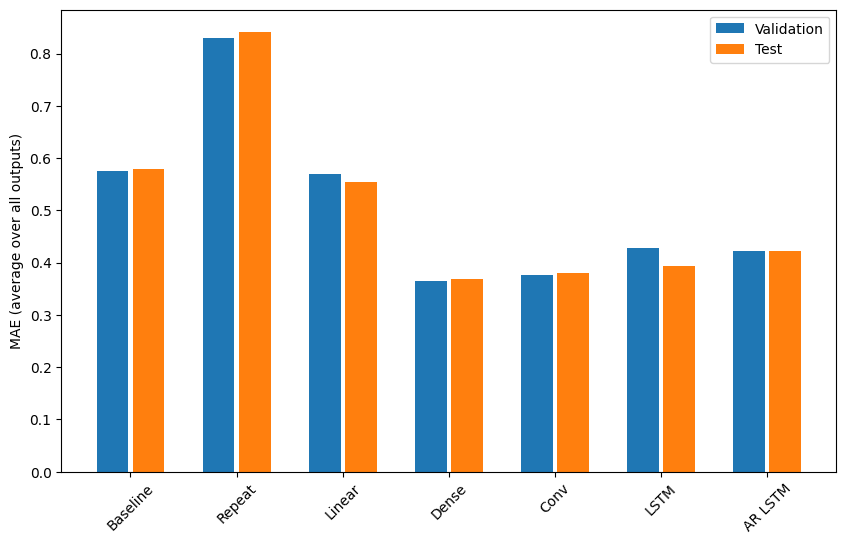

Baseline       : 0.5790
Repeat         : 0.8421
Linear         : 0.5551
Dense          : 0.3696
Conv           : 0.3795
LSTM           : 0.3929
AR LSTM        : 0.4228


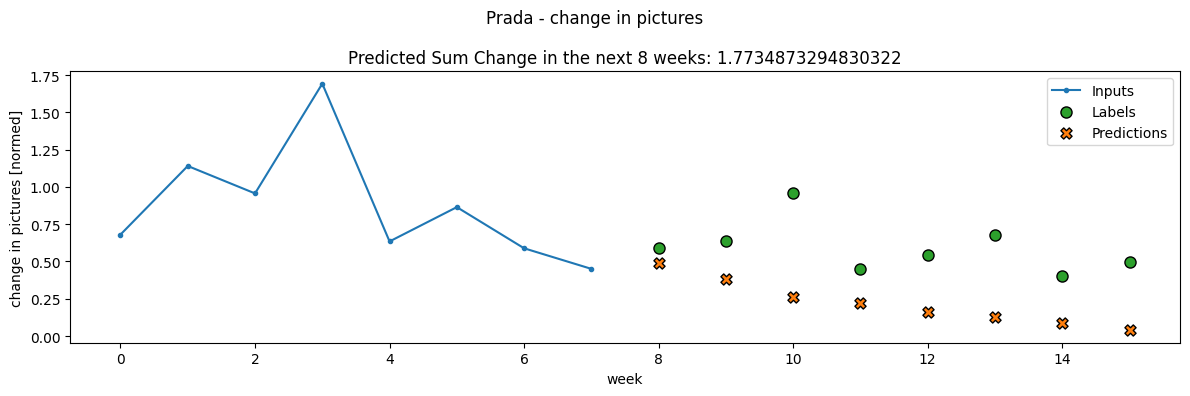

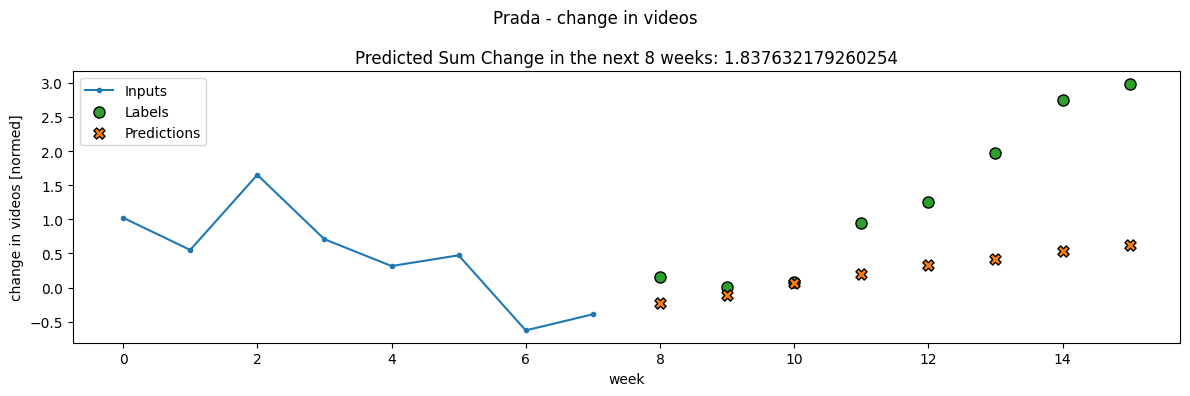

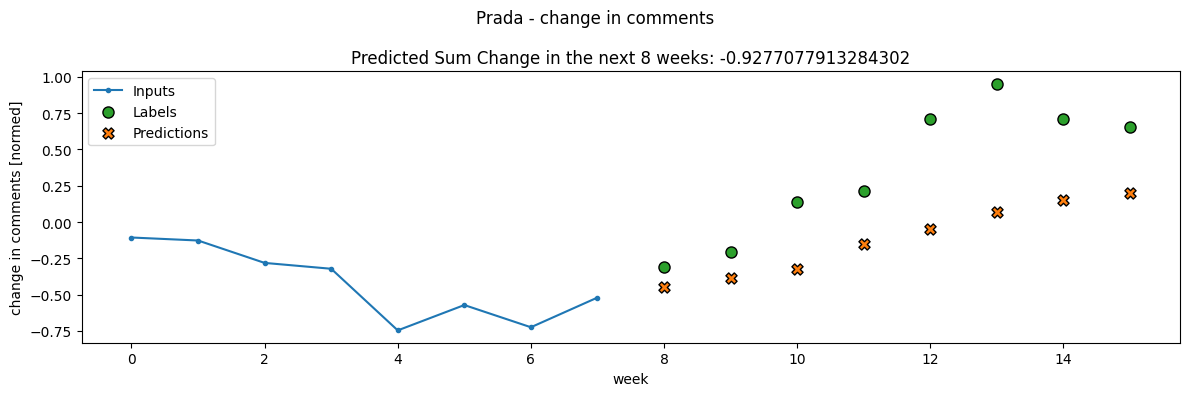

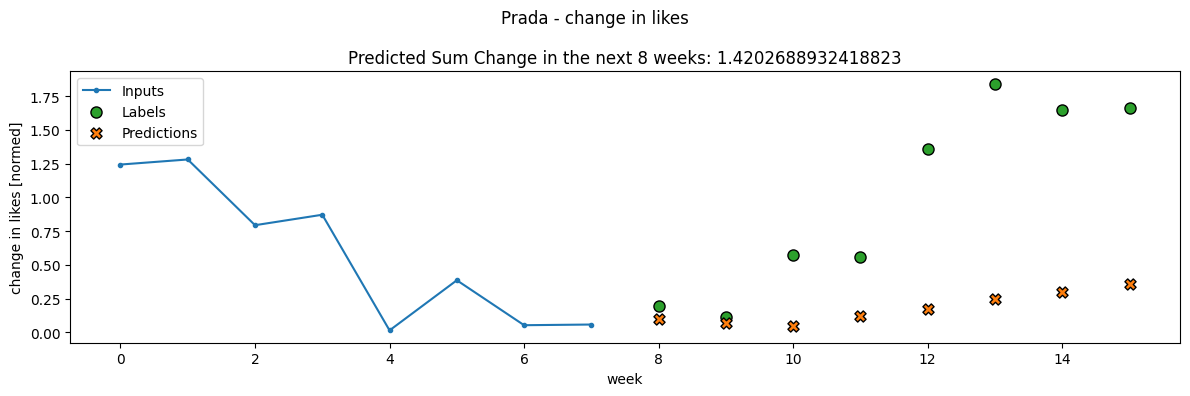

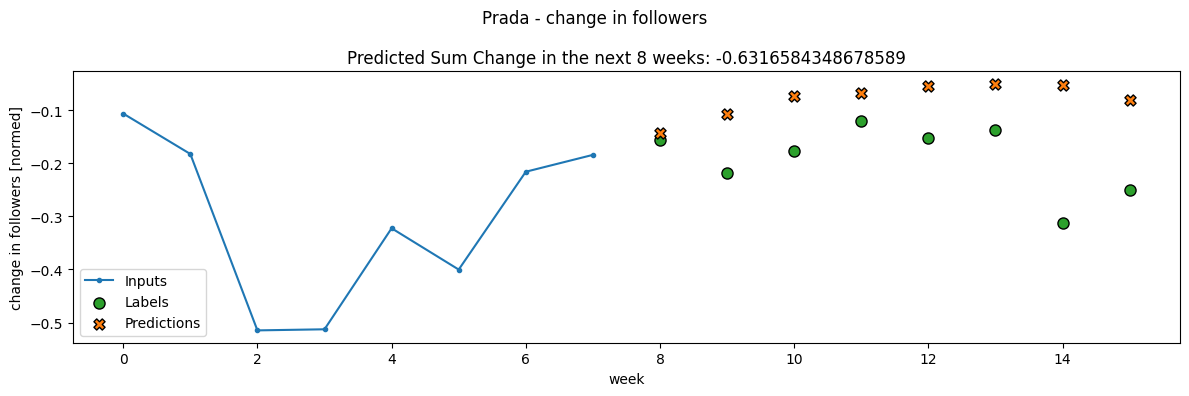

In [ ]:
predictions_dict = {}
columns_of_change = ['change in pictures', 'change in videos', 'change in comments',
       'change in likes', 'change in followers']
for i, brand in enumerate(brands):
    print(f"Training model for {brand} ({i+1}/{len(brands)})")
    df_brand = df[df['business_entity_doing_business_as_name'] == brand].drop(columns=['business_entity_doing_business_as_name'])
    best_model_name, best_model, window = train_eval_model_MM(df_brand, pred_step=8)
    
    inputs, labels = window.example
    predictions = best_model(inputs)
    predictions_dict[brand] = {}
    for column in columns_of_change:
        predictions_dict[brand][column] = predictions[0, : , window.column_indices[column]].numpy().sum()
        window.plot(best_model, plot_col=column)
        plt.suptitle(f"{brand} - {column}")
        plt.tight_layout()
        plt.show()

## 3. Evaluation of Model

- Evaluation of the model's performance and its ability to identify deviations.

**Mean Absolute Error** 
to compute the loss between the real number, like followers, and the predicted number of change in the future week. According to the above bar charts, the Dense model and CNN model outperforming others in most of the cases may benefits from the suitable complexity. In another words, the LSTM/AR-LSTM lead to overfitting easily. Overall, For different brands, the best model various each other. 

**Identify the Anomelies**
The predictions are the increamental number for each feature, which means, the higher of the predicted value, the higher possibility to be the next trends.

# Evaluation of Results

## Interpretation of the results

From Ranking the follower position and correlating the likes, comments, etc with followers, we get 2 thorough metrics for outlier detection. Using statistics or Machine Learning our analysis can be implement to easily detect significant deviations from common trends

The results show that correlations and ranking analysis are two powerpful metrics for understanding a complex pool of data

## Use of alternative approaches

We were able to code a solid foundation for further analysis. A series of small additional analysis will allow one for axhaustive analysis of the data. Some of that might include:

- Computing the variance in the parameters in different compset groups to get a sense for the volatility of the data by group
- Max to min ratio of the correlations for a sense of weight of the deviation
- computing the slope of the correlations to identify changes of the behaviour in time